<a href="https://colab.research.google.com/github/ArifAygun/ML_Calisma_Notebooklari/blob/main/STDAA_Graduate_Project_Iron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process**

# **(Percentage of Iron Concentrate)**

## **1. Problem Definition**

**Gangue concentrate predict in the reverse cationic flotation:**


Mined ores are mostly mixtures of extractable minerals and nonvaluable material (gangue). Mineral processing (e.g. ore dressing, ore beneficiation) follows mining and prepares the ore for extraction of the valuable metal. A principal step in mineral processing is physical separation of the particles of valuable minerals from the gangue, to produce an enriched portion (concentrate) containing most of the valuable minerals, and a discard (tailing) containing predominantly the gangue.

A separation of minerals by exploiting difference of surface properties (hydrophobicity) is called flotation. **The reverse cationic flotation** is commonly used to separate iron from silica. By adjusting the 'chemistry' of the pulp by adding various chemical reagents, iron minerals remain in the water and create sediment with a high concentration of iron (valuable minerals). At the same time, silica particles (gangue) attach to air bubbles and float to the surface.

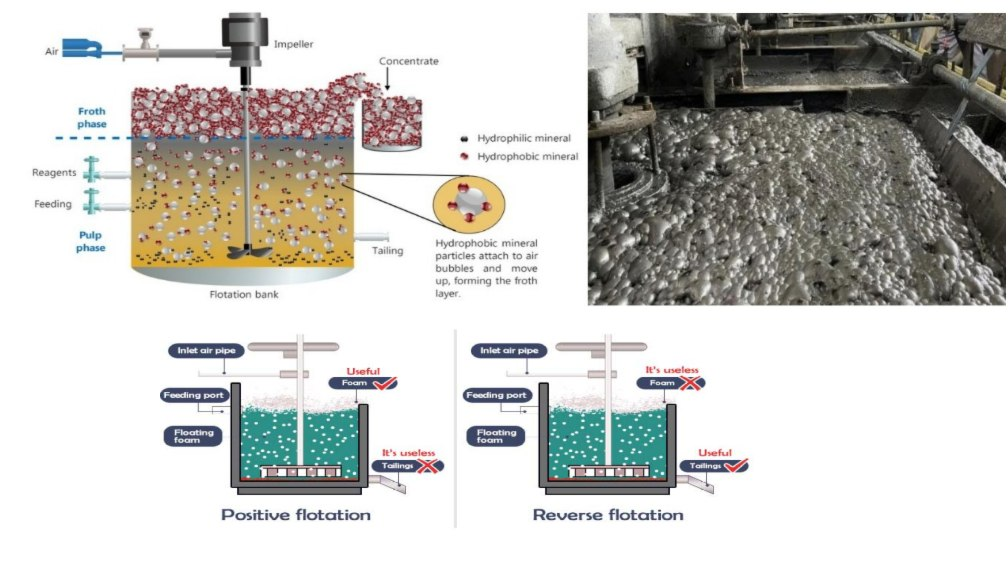

Flotation concentrate is periodically sampled to determine its purity (percentage of gangue). Higher purity in the concentrate is undesirable as it indicates that most valuable minerals had gone into the tailing. Purity measurement is usually done in a lab and can take some time before process engineers can make any adjustments based on the results. A timely investigation of concentrate purity is, therefore, a fundamental aspect for the control and optimization of the flotation process.

This project explores the application of machine learning to predict iron and gangue (silica) concentrate in the flotation output. The prediction will help process engineers assess the purity and take corrective actions in advance.

Source of dataset: https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

##**2. Data Understanding**

###**2.1. Data Definitions**

- **Date**: Data collection time. (There is imbalance in measurement of variables)
- **% Iron Feed**: Feed grade of iron-containing ore.
- **% Silica Feed**: Feed grade of silica-containing ore.
- **Starch Flow**: Depressant chemical for Iron(Fe) containing ore measured in m³/h.
- **Amina Flow**: Collector chemical for Silica containing ore measured in m³/h.
- **Ore Pulp Flow**: The amount of pulp flow fed to the flotation columns as the product of the previous process step measured in t/h.
- **Ore Pulp pH**: pH is measured in pH scale.
- **Ore Pulp Density**: The solid percent of ore fed density ranges in kg/cm³
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Air Flow**: Air Flows that goes into the flotation cell measured in Nm³/h.
- **Flotation Column 01, 02, 03, 04, 05, 06, 07 Level**: Froth level in the flotation cell measured in mm.
- **% Iron Concentrate**: Concentrate grade of iron-containing ore in percentage.
- **% Silica Concentrate**: Concentrate grade of silica-containing ore in percentage

### **2.2. Inspection of the data**

- The first column shows time and date range (march 2017 -  september 2017).
- Measurements are taken every 5-6 hours for the first 2 columns (input - raw material).
- Measurements are taken every 1 hour for the last 2 columns (output - processed material).
- Some columns were sampled every 20 second.
- The second and third columns are quality measures of the iron ore pulp right before it is fed into the flotation plant.
- From Column 4 until column 8 are the most important variables that impact in the ore quality in the end of the process.
- From column 9 until column 22, we can see process data (froth level and air flow inside the flotation columns, which also impact in ore quality).
- The last two columns are the final iron ore pulp quality measurement from the lab.

### **2.3. Aim of the Project**

- To predict the percentage of output (**iron concentrate**) in the mineral processing (reverse cationic flotation) plant

##**3. Data Collection**

###**3.1. Import Libraries**

In [104]:
import math
import random
import time
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
sns.set_theme(color_codes=True)
%matplotlib inline

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score

###**3.2. Import Dataset**

In [105]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/

flotation = pd.read_csv('Flotation_Plant.csv',
                        parse_dates = True,decimal=',')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


**Memory using reduction**

In [106]:
# Use a function to reduce memory usage of the dataframe by modifying the datatypes
def reduce_mem_usage(flotation, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = flotation.memory_usage().sum() / 1024**2
    for col in flotation.columns:
        col_type = flotation[col].dtypes
        if col_type in numerics:
            c_min = flotation[col].min()
            c_max = flotation[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    flotation[col] = flotation[col].astype(np.int8)
                elif c_min > flotation.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       flotation[col] = flotation[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    flotation[col] = flotation[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    flotation[col] = flotation[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    flotation[col] = flotation[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    flotation[col] = flotation[col].astype(np.float32)
                else:
                    flotation[col] = flotation[col].astype(np.float64)
    end_mem = flotation.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return flotation

flotation = reduce_mem_usage(flotation)

Mem. usage decreased to 70.33 Mb (47.9% reduction)


##**4. Data Preprocessing**

###**4.1. Dataset Information**

In [107]:
flotation.sample(5).T

116333               280104  \
date                          2017-04-19 05:00:00  2017-05-27 03:00:00   
% Iron Feed                             57.119999            64.029999   
% Silica Feed                               13.04                 6.26   
Starch Flow                           1116.323242           3029.02002   
Amina Flow                             343.877014           437.011993   
Ore Pulp Flow                          399.837006            401.73999   
Ore Pulp pH                               9.56738              9.96995   
Ore Pulp Density                         1.543144              1.65293   
Flotation Column 01 Air Flow              219.987           299.839996   
Flotation Column 02 Air Flow              215.528           304.733002   
Flotation Column 03 Air Flow           221.434998           302.265015   
Flotation Column 04 Air Flow           300.532654           299.584015   
Flotation Column 05 Air Flow           297.961151            299.32901   
Flotation Column 06 Air Flow           250.048996              294.056   
Flotation Column 07 Air Flow           251.050003           296.789001   
Flotation Column 01 Level              703.205994           608.427002   
Flotation Column 02 Level               703.83197           609.653015   
Flotation Column 03 Level              701.935974           602.094971   
Flotation Column 04 Level               389.84201            508.11499   
Flotation Column 05 Level              391.463013           499.186005   
Flotation Column 06 Level              463.544006           463.255005   
Flotation Column 07 Level              403.352997           528.549988   
% Iron Concentrate                      64.809998            65.110001   
% Silica Concentrate                         1.87                  2.6   

                                           196214               708380  \
date                          2017-05-07 17:00:00  2017-09-03 06:00:00   
% Iron Feed                             56.650002                54.73   
% Silica Feed                               14.83                15.69   
Starch Flow                           3705.219971           755.643311   
Amina Flow                             465.027008            482.36499   
Ore Pulp Flow                           399.61499           379.971985   
Ore Pulp pH                               10.0259               9.5936   
Ore Pulp Density                          1.70699              1.72136   
Flotation Column 01 Air Flow           250.091995           298.968994   
Flotation Column 02 Air Flow           250.725998           298.007996   
Flotation Column 03 Air Flow           249.380997           298.458008   
Flotation Column 04 Air Flow           300.942993           294.907806   
Flotation Column 05 Air Flow           299.220001           291.210358   
Flotation Column 06 Air Flow           299.949005           353.126007   
Flotation Column 07 Air Flow           301.645996           301.643005   
Flotation Column 01 Level              447.113007           612.049988   
Flotation Column 02 Level              435.213989            522.39502   
Flotation Column 03 Level              445.078003           502.769989   
Flotation Column 04 Level              393.959015           400.348999   
Flotation Column 05 Level              398.315002           385.192993   
Flotation Column 06 Level              328.355011           511.062012   
Flotation Column 07 Level              445.937012           398.484985   
% Iron Concentrate                      64.550003            64.440002   
% Silica Concentrate                         3.59                 2.01   

                                           293847  
date                          2017-05-30 07:00:00  
% Iron Feed                             64.029999  
% Silica Feed                                6.26  
Starch Flow                           3511.409912  
Amina Flow                             415.421997  
Ore Pulp Flow                

In [108]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737453 entries, 0 to 737452
Data columns (total 24 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date                          737453 non-null  object 
 1   % Iron Feed                   737453 non-null  float32
 2   % Silica Feed                 737453 non-null  float32
 3   Starch Flow                   737453 non-null  float32
 4   Amina Flow                    737453 non-null  float32
 5   Ore Pulp Flow                 737453 non-null  float32
 6   Ore Pulp pH                   737453 non-null  float32
 7   Ore Pulp Density              737453 non-null  float32
 8   Flotation Column 01 Air Flow  737453 non-null  float32
 9   Flotation Column 02 Air Flow  737453 non-null  float32
 10  Flotation Column 03 Air Flow  737453 non-null  float32
 11  Flotation Column 04 Air Flow  737453 non-null  float32
 12  Flotation Column 05 Air Flow  737453 non-nul

In [109]:
flotation.describe().T

count         mean          std         min  \
% Iron Feed                   737453.0    56.294743     5.157743   42.740002   
% Silica Feed                 737453.0    14.651719     6.807439    1.310000   
Starch Flow                   737453.0  2869.140381  1215.203735    0.002026   
Amina Flow                    737453.0   488.144653    91.230537  241.669006   
Ore Pulp Flow                 737453.0   397.578400     9.699785  376.248993   
Ore Pulp pH                   737453.0     9.767639     0.387007    8.753340   
Ore Pulp Density              737453.0     1.680380     0.069249    1.519820   
Flotation Column 01 Air Flow  737453.0   280.151886    29.621286  175.509995   
Flotation Column 02 Air Flow  737453.0   277.159973    30.149357  175.156006   
Flotation Column 03 Air Flow  737453.0   281.082489    28.558270  176.468994   
Flotation Column 04 Air Flow  737453.0   299.447845     2.572536  292.195007   
Flotation Column 05 Air Flow  737453.0   299.917816     3.636578  286.295013   
Flotation Column 06 Air Flow  737453.0   292.071503    30.217804  189.927994   
Flotation Column 07 Air Flow  737453.0   290.754883    28.670105  185.962006   
Flotation Column 01 Level     737453.0   520.244812   131.014923  149.218002   
Flotation Column 02 Level     737453.0   522.649597   128.165054  210.751999   
Flotation Column 03 Level     737453.0   531.352661   150.842163  126.254997   
Flotation Column 04 Level     737453.0   420.320984    91.794434  162.201004   
Flotation Column 05 Level     737453.0   425.251648    84.535820  166.990997   
Flotation Column 06 Level     737453.0   429.941040    89.862228  155.841003   
Flotation Column 07 Level     737453.0   421.021271    84.891495  175.348999   
% Iron Concentrate            737453.0    65.050049     1.118645   62.049999   
% Silica Concentrate          737453.0     2.326763     1.125554    0.600000   

                                      25%          50%          75%  \
% Iron Feed                     52.669998    56.080002    59.720001   
% Silica Feed                    8.940000    13.850000    19.600000   
Starch Flow                   2076.320068  3018.429932  3727.729980   
Amina Flow                     431.795990   504.393005   553.257019   
Ore Pulp Flow                  394.264008   399.248993   402.967987   
Ore Pulp pH                      9.527360     9.798100    10.038000   
Ore Pulp Density                 1.647310     1.697600     1.728330   
Flotation Column 01 Air Flow   250.281006   299.343994   300.148987   
Flotation Column 02 Air Flow   250.457001   296.222992   300.690002   
Flotation Column 03 Air Flow   250.854996   298.696014   300.381989   
Flotation Column 04 Air Flow   298.262573   299.804993   300.638000   
Flotation Column 05 Air Flow   298.067993   299.887115   301.791138   
Flotation Column 06 Air Flow   262.540985   299.476990   303.061005   
Flotation Column 07 Air Flow   256.302002   299.010986   301.903992   
Flotation Column 01 Level      416.977997   491.877991   594.114014   
Flotation Column 02 Level      441.882996   495.955994   595.463989   
Flotation Column 03 Level      411.325012   494.317993   601.249023   
Flotation Column 04 Level      356.678986   411.973999   485.549011   
Flotation Column 05 Level      357.653015   408.773010   484.329010   
Flotation Column 06 Level      358.497009   424.664581   492.683990   
Flotation Column 07 Level      356.772003   411.065002   476.464996   
% Iron Concentrate              64.370003    65.209999    65.860001   
% Silica Concentrate             1.440000     2.000000     3.010000   

                                      max  
% Iron Feed                     65.779999  
% Silica Feed                   33.400002  
Starch Flow                   6300.229980  
Amina Flow                     739.538025  
Ore Pulp Flow                  418.640991  
Ore Pulp pH                     10.808100  
Ore Pulp Density                 1.853250  
Flotation Column 01 Air Flow   373.871002  
Flotation C

###**4.2. Adjust and rename too long column names:**

In [110]:
flotation.columns

Index(['date', '% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate'],
      dtype='object')

In [111]:
# Rename column names
old_columns = ['% Iron Feed', '% Silica Feed', 'Starch Flow', 'Amina Flow',
       'Ore Pulp Flow', 'Ore Pulp pH', 'Ore Pulp Density',
       'Flotation Column 01 Air Flow', 'Flotation Column 02 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 05 Air Flow', 'Flotation Column 06 Air Flow',
       'Flotation Column 07 Air Flow', 'Flotation Column 01 Level',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       'Flotation Column 04 Level', 'Flotation Column 05 Level',
       'Flotation Column 06 Level', 'Flotation Column 07 Level',
       '% Iron Concentrate', '% Silica Concentrate']

new_columns = ["feed_Fe","feed_Si", "starch_flow", "amina_flow",
               "pulp_flow", "pulp_pH", "pulp_density",
               "air1", "air2", "air3", "air4", "air5", "air6", "air7",
               "level1", "level2", "level3", "level4", "level5", "level6", "level7",
               "conc_Fe", "conc_Si"]

flotation = flotation.rename(columns=dict(zip(old_columns, new_columns)))
flotation.columns

Index(['date', 'feed_Fe', 'feed_Si', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'air1', 'air2', 'air3', 'air4', 'air5',
       'air6', 'air7', 'level1', 'level2', 'level3', 'level4', 'level5',
       'level6', 'level7', 'conc_Fe', 'conc_Si'],
      dtype='object')

The dataframe contains data about:

- Quality measures of the iron ore pulp before feeding it into the process (**inputs**)
- Features that can effect the quality of the product (**process parameters**)
- Quality measures of the iron ore pulp as product of the process (**outputs**)

### **4.3. Plot the variables graphs in time:**

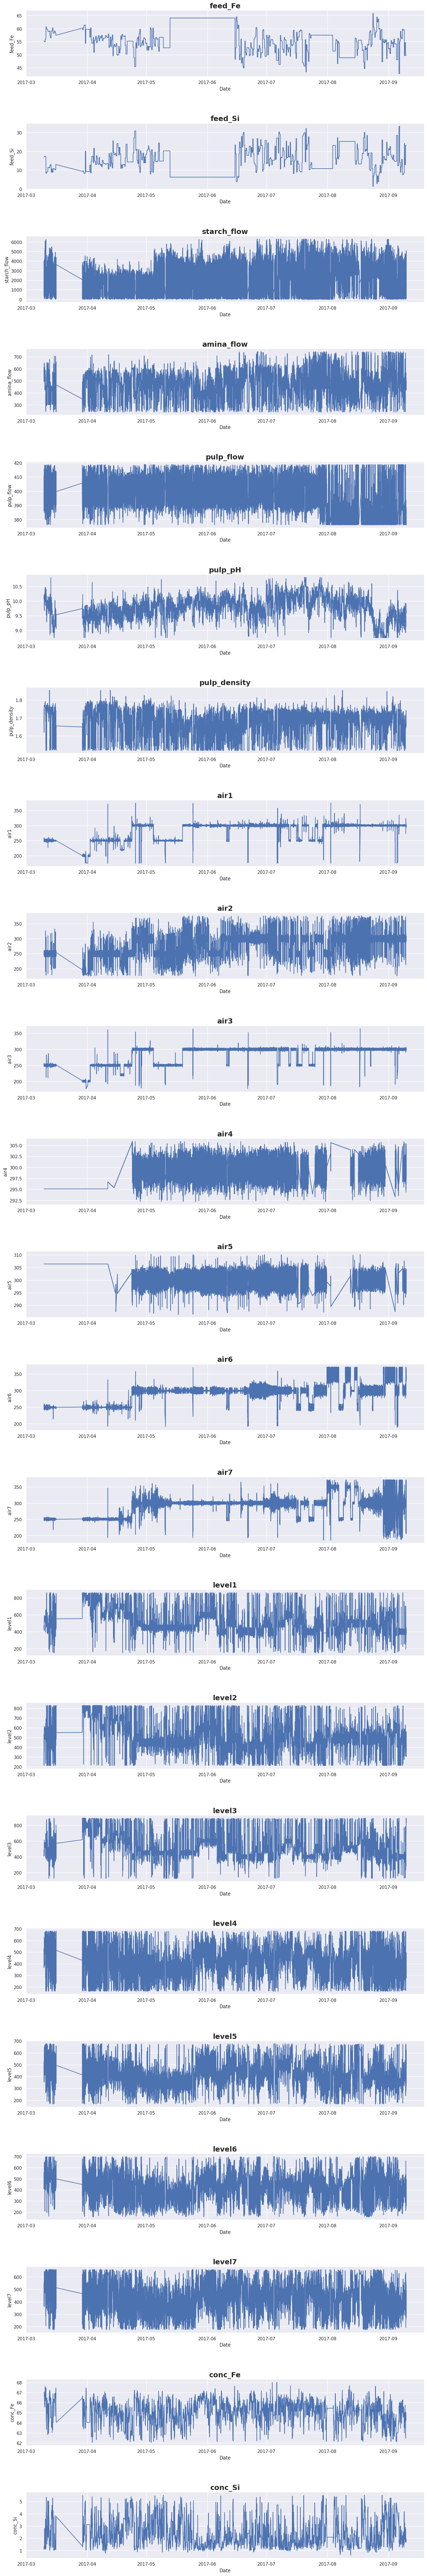

In [112]:
# Convert 'date' column to datetime type
flotation['date'] = pd.to_datetime(flotation['date'])

# Set 'date' column as the index
flotation.set_index('date', inplace=True)

columns = flotation.columns

num_columns = 1
num_rows = (len(columns) - 1) // num_columns + 1

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 90))
axes = axes.flatten()

for i, column in enumerate(columns):
    axes[i].plot(flotation.index, flotation[column])
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(column)
    axes[i].set_title(column, fontsize=18, fontweight='bold')

if len(columns) < len(axes):
    for j in range(len(columns), len(axes)):
        axes[j].axis('off')

plt.tight_layout(h_pad=5)
plt.show()

The dataset misses data packages of a couple of days. This was probably caused by a production shutdown. In order to rule out any influences from potentially corrupted data, it will be trimmed the data earlier of the restart of production ("2017-03-29 12:00:00"). We can also see that the quality of the products does not seem to follow a clear temporal dependency.

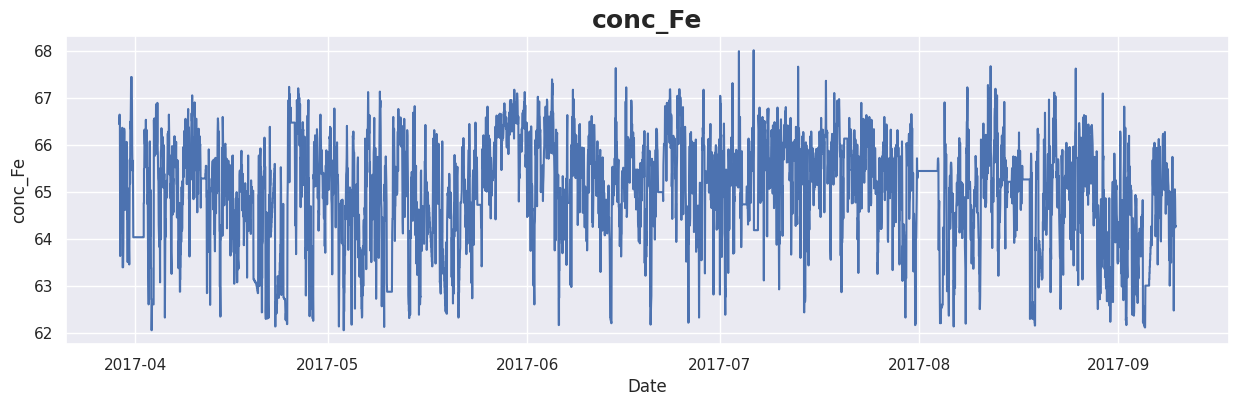

In [113]:
sep_date = "2017-03-29 12:00:00"

# Trim the dataset by filtering rows after the specified sep_date
flotation = flotation[flotation.index >= sep_date]

plt.figure(figsize=(15, 4))
plt.plot(flotation.index, flotation['conc_Fe'])
plt.xlabel('Date')
plt.ylabel('conc_Fe')
plt.title('conc_Fe', fontsize=18, fontweight='bold')
plt.show()

In [114]:
flotation.head().T

date          2017-03-29 12:00:00  2017-03-29 12:00:00  2017-03-29 12:00:00  \
feed_Fe                 60.180000            60.180000            60.180000   
feed_Si                  9.340000             9.340000             9.340000   
starch_flow           2044.989990          2020.550049          2012.839966   
amina_flow             349.911011           353.063995           356.217010   
pulp_flow              405.625000           404.402008           403.179993   
pulp_pH                  9.746040             9.741690             9.737330   
pulp_density             1.649650             1.643469             1.637289   
air1                   200.393005           200.130997           199.869003   
air2                   195.733994           196.475998           197.218994   
air3                   201.826004           200.908997           199.992004   
air4                   295.096008           295.096008           295.096008   
air5                   306.399994           306.399994           306.399994   
air6                   250.600998           250.207993           249.815002   
air7                   251.001999           250.828003           250.653000   
level1                 555.264465           557.839905           560.415405   
level2                 552.255554           554.531128           556.806702   
level3                 614.984741           659.557434           704.130127   
level4                 428.429993           431.145996           433.863007   
level5                 413.661987           422.308014           430.954010   
level6                 447.886993           444.325989           440.765015   
level7                 464.868988           463.223999           461.579010   
conc_Fe                 66.440002            66.440002            66.440002   
conc_Si                  1.360000             1.360000             1.360000   

date          2017-03-29 12:00:00  2017-03-29 12:00:00  
feed_Fe                 60.180000            60.180000  
feed_Si                  9.340000             9.340000  
starch_flow           2007.670044          2003.920044  
amina_flow             359.371002           362.523987  
pulp_flow              401.957001           400.734985  
pulp_pH                  9.732980             9.728620  
pulp_density             1.631108             1.624928  
air1                   199.606995           199.345001  
air2                   197.960999           198.703003  
air3                   199.074997           198.158005  
air4                   295.096008           295.096008  
air5                   306.399994           306.399994  
air6                   249.421997           249.029007  
air7                   250.477997           250.304001  
level1                 562.990845           565.566345  
level2                 559.082275           561.357849  
level3                 748.702881           793.275574  
level4                 436.579987           439.295990  
level5                 439.600006           448.246002  
level6                 437.204010           433.643005  
level7                 459.934998           458.290009  
conc_Fe                 66.440002            66.440002  
conc_Si                  1.360000             1.360000

- That revealed a high (negative) correlations between the 'Iron Feed' and 'Silica Feed' (both Inputs of the process) as well as 'Iron Concentrate' and 'Silica Concentrate' (both Outputs of the process from the lab measurement).
- This situation basically says, higher the quality of the Iron, the less Silica it contains.

In [115]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 710639 entries, 2017-03-29 12:00:00 to 2017-09-09 23:00:00
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   feed_Fe       710639 non-null  float32
 1   feed_Si       710639 non-null  float32
 2   starch_flow   710639 non-null  float32
 3   amina_flow    710639 non-null  float32
 4   pulp_flow     710639 non-null  float32
 5   pulp_pH       710639 non-null  float32
 6   pulp_density  710639 non-null  float32
 7   air1          710639 non-null  float32
 8   air2          710639 non-null  float32
 9   air3          710639 non-null  float32
 10  air4          710639 non-null  float32
 11  air5          710639 non-null  float32
 12  air6          710639 non-null  float32
 13  air7          710639 non-null  float32
 14  level1        710639 non-null  float32
 15  level2        710639 non-null  float32
 16  level3        710639 non-null  float32
 17  level4        

## **4.5. Averaging dataset to account for differently sampled features**

Based on the dataset documentation, it is observed that certain columns are sampled at different frequencies, with some features being recorded every 20 seconds while others are sampled hourly. For example, the feature 'Ore Pulp Flow' exhibits continuous changes throughout the process, while '% Iron Feed' and '% Silica Feed' are only recorded once every hour. It is important to consider the nature of these sampling frequencies as it impacts the representation of the data.

Treating each row as an individual observation may not accurately reflect the reality of the process, particularly when including less frequently sampled features that remain constant over the course of an hour. Simply using all samples for training a model fails to capture the true dynamics of the system.

One approach is to aggregate the data by calculating the mean of the 20-second samples for each hour, resulting in a new dataframe that represents the hourly average values. This reduction in data size, by a factor of 180, allows for a more meaningful representation of the hourly trends. However, solely relying on the mean values might lead to the loss of important information contained in the 20-second samples.

To mitigate the loss of information from the 20-second samples, it is beneficial to consider their variations within each hour. One way to incorporate this variability is by calculating additional statistics such as the standard deviation of the meaned columns. By including these measures of variation, we can capture the dynamics and fluctuations within the hourly intervals, providing a more comprehensive representation of the process.

Taking into account the varying sampling frequencies in the dataset and considering the trade-off between data size reduction and information loss, aggregating the data to hourly means along with measures of variability can provide a more meaningful representation of the process dynamics for further analysis and modeling.

In [116]:
flotation_mean = flotation.copy()

# Convert the index to datetime if it's not already
flotation_mean.index = pd.to_datetime(flotation_mean.index)
# Group the DataFrame by hourly intervals and calculate the mean
mean_grpby = flotation_mean.resample('1H').mean()
# Group the DataFrame by hourly intervals and calculate the standard deviation
std_grpby = flotation_mean.resample('1H').std()
# Remove columns with zero variance (null columns)
std_grpby = std_grpby.loc[:, (std_grpby != 0).any()]
# Add prefix 'std_' to the column names
std_grpby = std_grpby.add_prefix('std_')
# Merge the mean and standard deviation DataFrames on the index
flotation_merge = pd.concat([mean_grpby, std_grpby], axis=1)
# Assign the merged DataFrame back to 'flotation'
flotation = flotation_merge

flotation.describe().T

count         mean         std         min          25%  \
feed_Fe           3948.0    56.220303    5.231150   42.740002    52.610001   
feed_Si           3948.0    14.767789    6.887711    1.310000     8.812500   
starch_flow       3948.0  2847.013184  948.913513   54.595482  2146.232483   
amina_flow        3948.0   488.720673   83.769852  242.927475   436.428764   
pulp_flow         3948.0   397.471405    8.491449  376.837585   398.774376   
pulp_pH           3948.0     9.769642    0.378012    8.753389     9.542790   
pulp_density      3948.0     1.679042    0.063417    1.519926     1.649868   
air1              3948.0   281.287415   29.361843  175.885574   250.109676   
air2              3948.0   278.182037   29.490105  178.188431   250.119045   
air3              3948.0   282.253113   28.244196  177.202667   250.109154   
air4              3948.0   299.612000    2.317443  293.336670   299.798904   
air5              3948.0   299.673248    3.143090  287.056458   299.667374   
air6              3948.0   293.659271   28.978373  196.512085   299.193336   
air7              3948.0   292.293610   26.527575  199.728119   299.031685   
level1            3948.0   520.425293  123.756676  181.925613   409.067978   
level2            3948.0   523.195862  116.664619  224.909653   449.187202   
level3            3948.0   532.182373  140.549118  135.214508   402.250427   
level4            3948.0   418.095673   76.142143  165.725052   351.264366   
level5            3948.0   422.776672   74.612106  214.735901   350.829651   
level6            3948.0   426.996979   74.714157  203.702927   353.171867   
level7            3948.0   418.128754   71.636368  185.061386   350.734680   
conc_Fe           3948.0    65.027176    1.109367   62.049999    64.349998   
conc_Si           3948.0     2.322261    1.120117    0.600000     1.440000   
std_starch_flow   3948.0   637.218723  418.970757    0.000000   279.926341   
std_amina_flow    3948.0    28.508237   22.743188    0.000000    11.730148   
std_pulp_flow     3948.0     4.219826    2.476077    0.000000     3.204025   
std_pulp_pH       3948.0     0.067656    0.048902    0.000000     0.033031   
std_pulp_density  3948.0     0.020711    0.016908    0.000000     0.008554   
std_air1          3948.0     1.344958    3.366587    0.000000     0.485148   
std_air2          3948.0     5.016049    4.417979    0.000000     2.926173   
std_air3          3948.0     1.755695    2.830901    0.000000     1.240702   
std_air4          3948.0     0.689986    0.534008    0.000000     0.017487   
std_air5          3948.0     1.176693    0.910952    0.000000     0.036030   
std_air6          3948.0     4.563310    4.238823    0.000000     0.837859   
std_air7          3948.0     4.989875    7.731448    0.000000     1.409878   
std_level1        3948.0    26.683674   38.474046    0.000000     9.382263   
std_level2        3948.0    32.605215   41.797609    0.000000    10.653183   
std_level3        3948.0    32.821150   50.259170    0.000000     7.098469   
std_level4        3948.0    39.493906   29.877233    0.000000    19.490529   
std_level5        3948.0    29.191770   25.013944    0.000000    14.130165   
std_level6        3948.0    37.695776   31.817052    0.000000    15.788064   
std_level7        3948.0    36.329915   24.129453    0.000000    19.408954   
std_conc_Fe       3948.0     0.005046    0.039691    0.000000     0.000000   
std_conc_Si       3948.0     0.007109    0.045371    0.000000     0.000000   

                          50%          75%          max  
feed_Fe             55.940002    59.720005    65.779999  
feed_Si             14.200000    20.139999    33.400002  
starch_flow       2880.359009  3514.789795  6270.159180  
amina_flow         502.685959   550.144592   736.982361  
pulp_flow          399.835449   400.592918   418.070221  
pulp_pH              9.796512    10.033416    10.807370  
pulp_density         1.694900     1.719869     1.818191  
air1               299.850586   299.955673  

**Check missing and duplicated values:**

In [117]:
missing_values = flotation.isnull().sum()
missing_values

feed_Fe             0
feed_Si             0
starch_flow         0
amina_flow          0
pulp_flow           0
pulp_pH             0
pulp_density        0
air1                0
air2                0
air3                0
air4                0
air5                0
air6                0
air7                0
level1              0
level2              0
level3              0
level4              0
level5              0
level6              0
level7              0
conc_Fe             0
conc_Si             0
std_starch_flow     0
std_amina_flow      0
std_pulp_flow       0
std_pulp_pH         0
std_pulp_density    0
std_air1            0
std_air2            0
std_air3            0
std_air4            0
std_air5            0
std_air6            0
std_air7            0
std_level1          0
std_level2          0
std_level3          0
std_level4          0
std_level5          0
std_level6          0
std_level7          0
std_conc_Fe         0
std_conc_Si         0
dtype: int64

In [118]:
duplicates = flotation[flotation.duplicated()]
duplicates.count()

feed_Fe             0
feed_Si             0
starch_flow         0
amina_flow          0
pulp_flow           0
pulp_pH             0
pulp_density        0
air1                0
air2                0
air3                0
air4                0
air5                0
air6                0
air7                0
level1              0
level2              0
level3              0
level4              0
level5              0
level6              0
level7              0
conc_Fe             0
conc_Si             0
std_starch_flow     0
std_amina_flow      0
std_pulp_flow       0
std_pulp_pH         0
std_pulp_density    0
std_air1            0
std_air2            0
std_air3            0
std_air4            0
std_air5            0
std_air6            0
std_air7            0
std_level1          0
std_level2          0
std_level3          0
std_level4          0
std_level5          0
std_level6          0
std_level7          0
std_conc_Fe         0
std_conc_Si         0
dtype: int64

In [119]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3948 entries, 2017-03-29 12:00:00 to 2017-09-09 23:00:00
Freq: H
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   feed_Fe           3948 non-null   float32
 1   feed_Si           3948 non-null   float32
 2   starch_flow       3948 non-null   float32
 3   amina_flow        3948 non-null   float32
 4   pulp_flow         3948 non-null   float32
 5   pulp_pH           3948 non-null   float32
 6   pulp_density      3948 non-null   float32
 7   air1              3948 non-null   float32
 8   air2              3948 non-null   float32
 9   air3              3948 non-null   float32
 10  air4              3948 non-null   float32
 11  air5              3948 non-null   float32
 12  air6              3948 non-null   float32
 13  air7              3948 non-null   float32
 14  level1            3948 non-null   float32
 15  level2            3948 non-null   float32
 16

##**5. Exploratory Data Analysis**

###**5.1. Corellation Between the Variables**

In [120]:
flotation.describe().T

count         mean         std         min          25%  \
feed_Fe           3948.0    56.220303    5.231150   42.740002    52.610001   
feed_Si           3948.0    14.767789    6.887711    1.310000     8.812500   
starch_flow       3948.0  2847.013184  948.913513   54.595482  2146.232483   
amina_flow        3948.0   488.720673   83.769852  242.927475   436.428764   
pulp_flow         3948.0   397.471405    8.491449  376.837585   398.774376   
pulp_pH           3948.0     9.769642    0.378012    8.753389     9.542790   
pulp_density      3948.0     1.679042    0.063417    1.519926     1.649868   
air1              3948.0   281.287415   29.361843  175.885574   250.109676   
air2              3948.0   278.182037   29.490105  178.188431   250.119045   
air3              3948.0   282.253113   28.244196  177.202667   250.109154   
air4              3948.0   299.612000    2.317443  293.336670   299.798904   
air5              3948.0   299.673248    3.143090  287.056458   299.667374   
air6              3948.0   293.659271   28.978373  196.512085   299.193336   
air7              3948.0   292.293610   26.527575  199.728119   299.031685   
level1            3948.0   520.425293  123.756676  181.925613   409.067978   
level2            3948.0   523.195862  116.664619  224.909653   449.187202   
level3            3948.0   532.182373  140.549118  135.214508   402.250427   
level4            3948.0   418.095673   76.142143  165.725052   351.264366   
level5            3948.0   422.776672   74.612106  214.735901   350.829651   
level6            3948.0   426.996979   74.714157  203.702927   353.171867   
level7            3948.0   418.128754   71.636368  185.061386   350.734680   
conc_Fe           3948.0    65.027176    1.109367   62.049999    64.349998   
conc_Si           3948.0     2.322261    1.120117    0.600000     1.440000   
std_starch_flow   3948.0   637.218723  418.970757    0.000000   279.926341   
std_amina_flow    3948.0    28.508237   22.743188    0.000000    11.730148   
std_pulp_flow     3948.0     4.219826    2.476077    0.000000     3.204025   
std_pulp_pH       3948.0     0.067656    0.048902    0.000000     0.033031   
std_pulp_density  3948.0     0.020711    0.016908    0.000000     0.008554   
std_air1          3948.0     1.344958    3.366587    0.000000     0.485148   
std_air2          3948.0     5.016049    4.417979    0.000000     2.926173   
std_air3          3948.0     1.755695    2.830901    0.000000     1.240702   
std_air4          3948.0     0.689986    0.534008    0.000000     0.017487   
std_air5          3948.0     1.176693    0.910952    0.000000     0.036030   
std_air6          3948.0     4.563310    4.238823    0.000000     0.837859   
std_air7          3948.0     4.989875    7.731448    0.000000     1.409878   
std_level1        3948.0    26.683674   38.474046    0.000000     9.382263   
std_level2        3948.0    32.605215   41.797609    0.000000    10.653183   
std_level3        3948.0    32.821150   50.259170    0.000000     7.098469   
std_level4        3948.0    39.493906   29.877233    0.000000    19.490529   
std_level5        3948.0    29.191770   25.013944    0.000000    14.130165   
std_level6        3948.0    37.695776   31.817052    0.000000    15.788064   
std_level7        3948.0    36.329915   24.129453    0.000000    19.408954   
std_conc_Fe       3948.0     0.005046    0.039691    0.000000     0.000000   
std_conc_Si       3948.0     0.007109    0.045371    0.000000     0.000000   

                          50%          75%          max  
feed_Fe             55.940002    59.720005    65.779999  
feed_Si             14.200000    20.139999    33.400002  
starch_flow       2880.359009  3514.789795  6270.159180  
amina_flow         502.685959   550.144592   736.982361  
pulp_flow          399.835449   400.592918   418.070221  
pulp_pH              9.796512    10.033416    10.807370  
pulp_density         1.694900     1.719869     1.818191  
air1               299.850586   299.955673  

### **5.2. Pearson correlations between variables:**

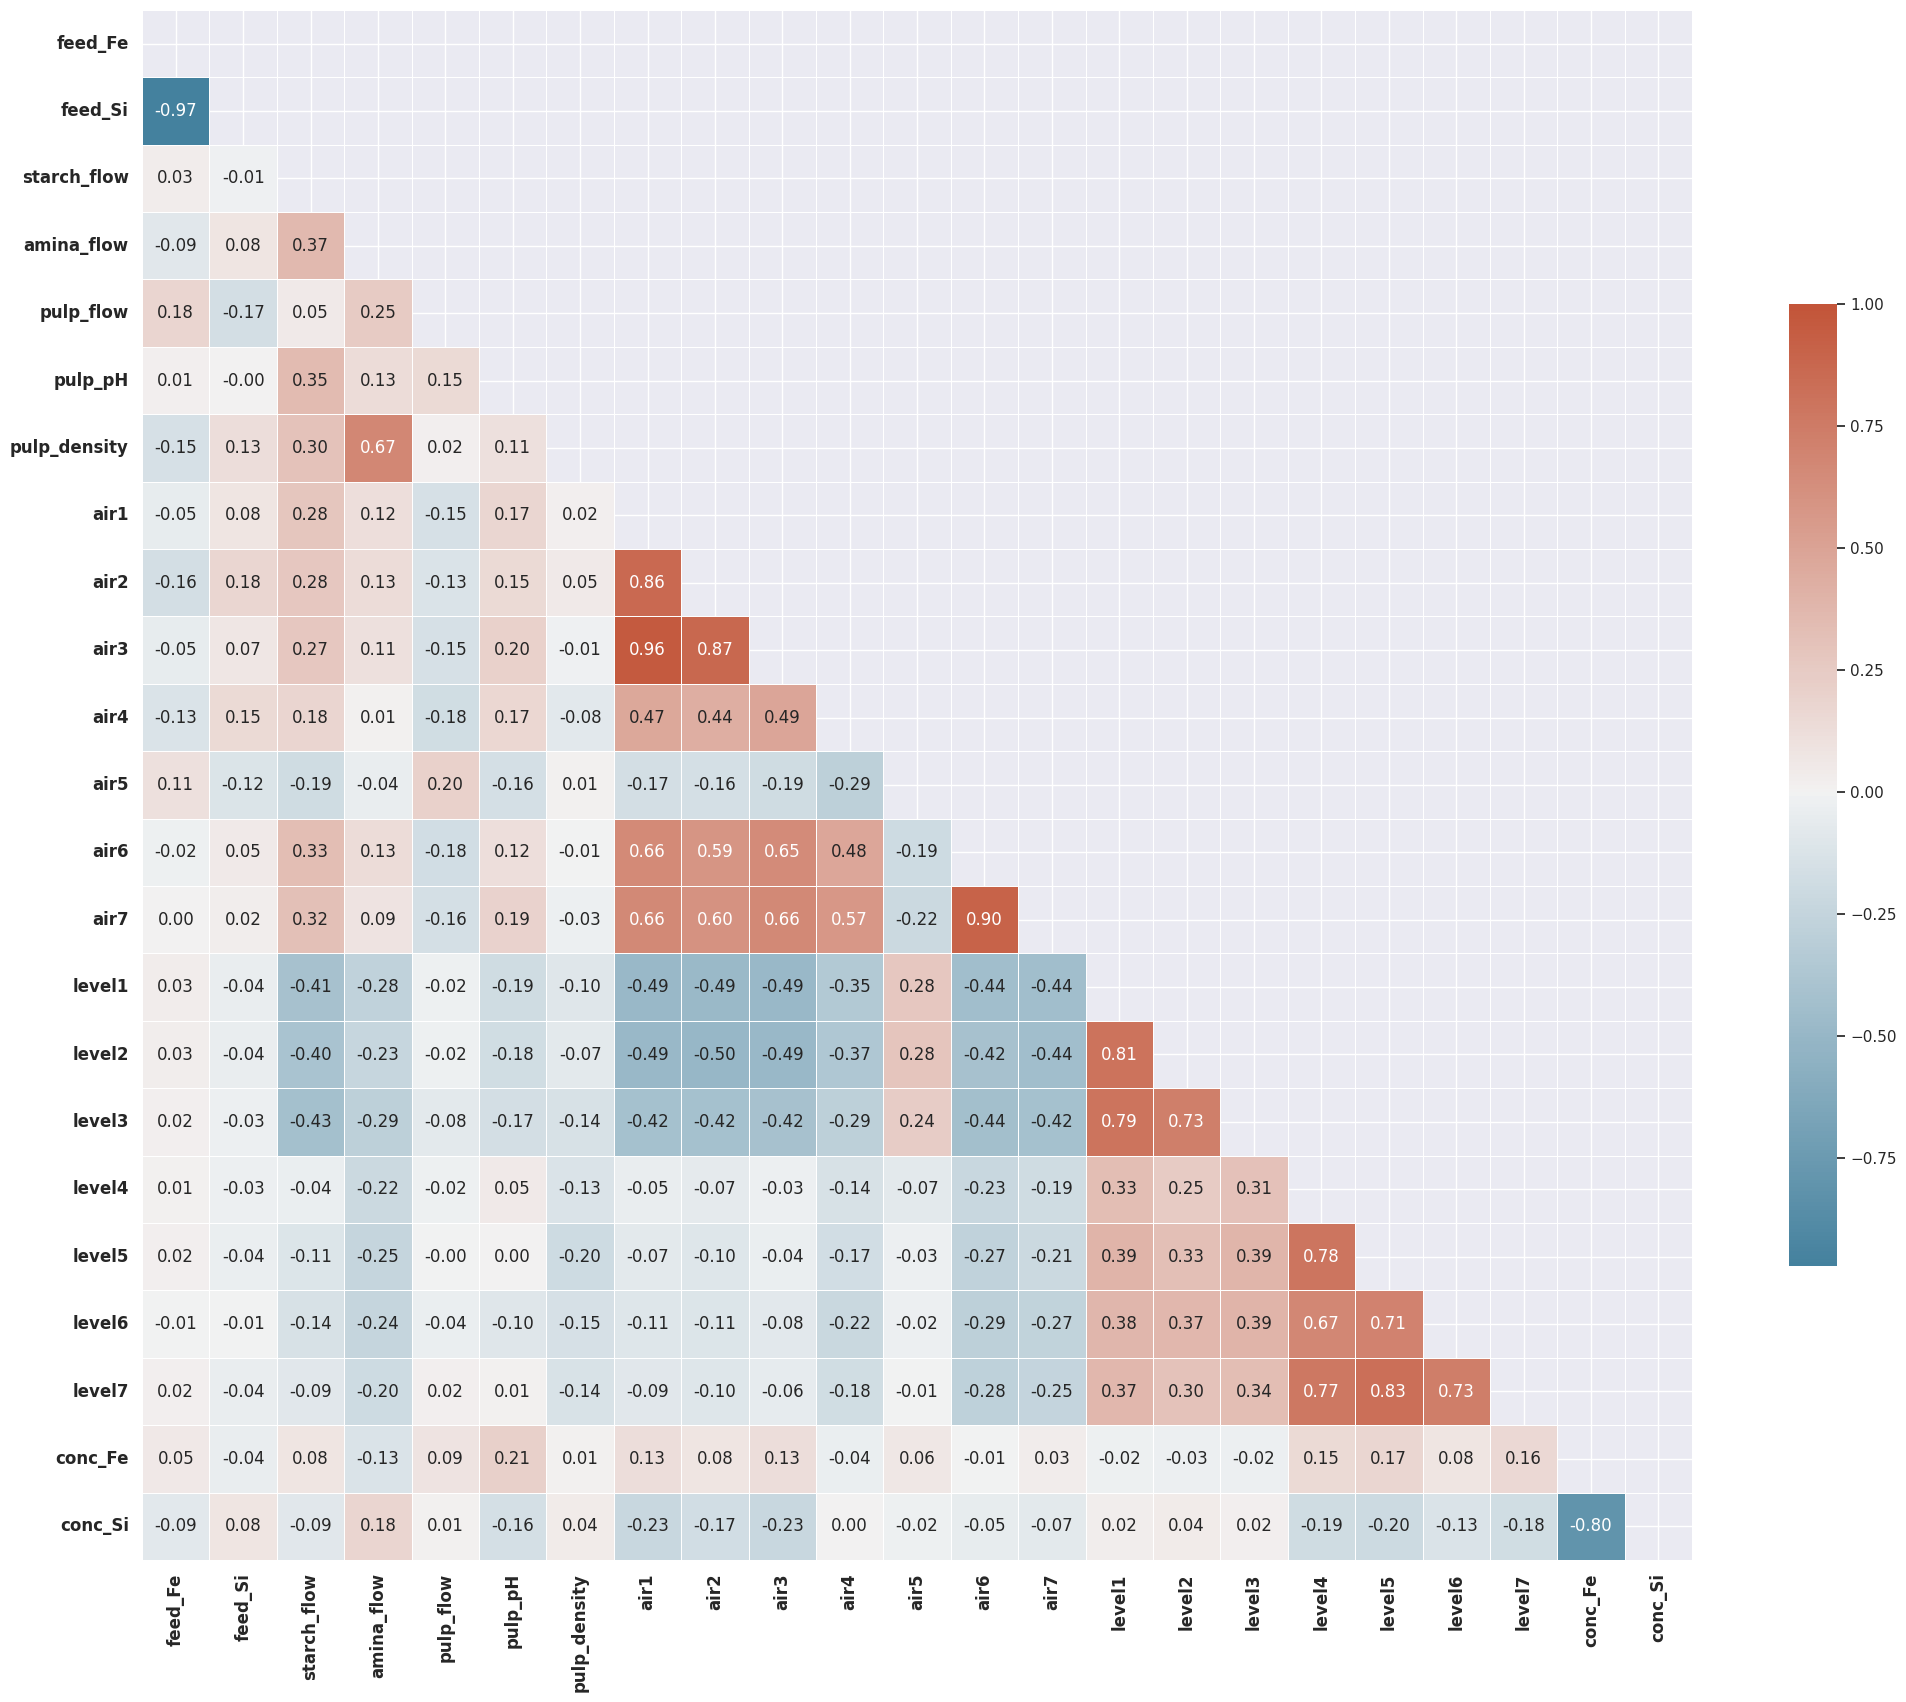

In [121]:
subset = flotation.loc[:, ~flotation.columns.str.startswith('std')]

# Calculate the correlation matrix
mat = subset.corr('pearson')

mask = np.triu(np.ones_like(mat, dtype=bool))
f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Plot the correlation heatmap
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1,
            center=0, annot=True, square=True,
            linewidths=.5, annot_kws={"fontsize": 12},
            cbar_kws={"shrink": .5}, fmt='.2f')

# Set x and y axis tick font properties
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.show()

### **5.2. Relationships between target variable (Iron Concentrate) and Independent variables**

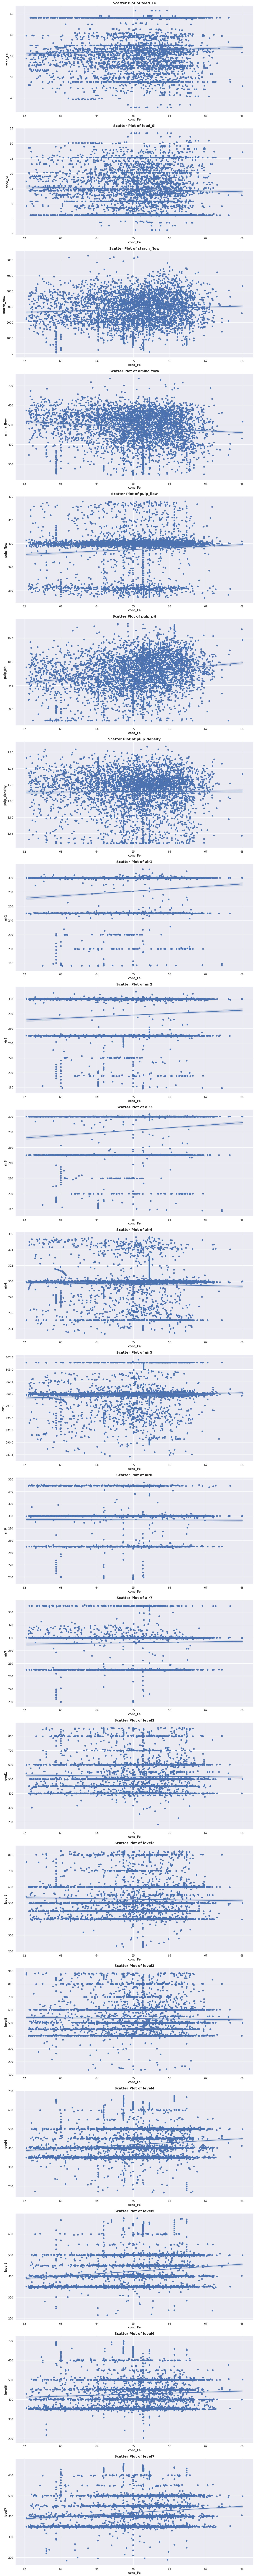

In [122]:
fig, axs = plt.subplots(21, 1, figsize=(15, 150))
axs = axs.flatten()

for i in range(21):
    col = flotation.columns[i]
    sns.scatterplot(data=flotation, x='conc_Fe', y=col, ax=axs[i])
    sns.regplot(data=flotation, x='conc_Fe', y=col, ax=axs[i])
    axs[i].set_title(f'Scatter Plot of {col}', fontsize=14, fontweight='bold')
    axs[i].set_xlabel('conc_Fe', fontsize=12, fontweight='bold')
    axs[i].set_ylabel(col, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

### **5.3. P-values of Silica Concentrate vs Features**

In [123]:
from scipy.stats import pearsonr

target_variable = 'conc_Fe'

variables = [col for col in flotation.columns if not col.startswith('std')]

correlation_data = []

for variable in variables:
    if variable != target_variable:
        # Calculate the correlation coefficient and p-value between the target variable and the current variable
        correlation_coefficient, p_value = pearsonr(flotation[target_variable], flotation[variable])
        # Create a DataFrame with the correlation data
        df = pd.DataFrame({
            'Variable': variable,
            'Correlation Coefficient': correlation_coefficient,
            'p-value': p_value
        }, index=[0])
        # Append the DataFrame to the list
        correlation_data.append(df)

# Concatenate the correlation DataFrames into a single DataFrame
correlation_df = pd.concat(correlation_data, ignore_index=True)

# Sort the correlation DataFrame by the absolute value of the correlation coefficient
correlation_df['Absolute Correlation'] = np.abs(correlation_df['Correlation Coefficient'])
correlation_df.sort_values('Absolute Correlation', ascending=False, inplace=True)
correlation_df = correlation_df.round(3)

correlation_df

Variable  Correlation Coefficient  p-value  Absolute Correlation
21       conc_Si                   -0.803    0.000                 0.803
5        pulp_pH                    0.207    0.000                 0.207
18        level5                    0.168    0.000                 0.168
20        level7                    0.156    0.000                 0.156
17        level4                    0.152    0.000                 0.152
9           air3                    0.129    0.000                 0.129
7           air1                    0.126    0.000                 0.126
3     amina_flow                   -0.126    0.000                 0.126
4      pulp_flow                    0.091    0.000                 0.091
8           air2                    0.082    0.000                 0.082
19        level6                    0.077    0.000                 0.077
2    starch_flow                    0.076    0.000                 0.076
11          air5                    0.063    0.000                 0.063
0        feed_Fe                    0.054    0.001                 0.054
1        feed_Si                   -0.043    0.007                 0.043
10          air4                   -0.038    0.016                 0.038
15        level2                   -0.031    0.054                 0.031
13          air7                    0.030    0.059                 0.030
16        level3                   -0.025    0.120                 0.025
14        level1                   -0.018    0.246                 0.018
6   pulp_density                    0.010    0.515                 0.010
12          air6                   -0.009    0.581                 0.009

In [124]:
from scipy.stats import pearsonr

# Define the target variable
target_variable = 'conc_Fe'

# Get the list of variables
variables = [col for col in flotation.columns if not col.startswith('std')]

# Create an empty list to store the correlation data
correlation_data = []

# Loop through the variables
for variable in variables:
    if variable != target_variable:
        # Calculate the correlation coefficient and p-value between the target variable and the current variable
        correlation_coefficient, p_value = pearsonr(flotation[target_variable], flotation[variable])

        # Create a DataFrame with the correlation data
        df = pd.DataFrame({
            'Variable': variable,
            'Correlation Coefficient': correlation_coefficient,
            'p-value': p_value
        }, index=[0])

        # Append the DataFrame to the list
        correlation_data.append(df)

# Concatenate the correlation DataFrames into a single DataFrame
correlation_df = pd.concat(correlation_data, ignore_index=True)

# Sort the correlation DataFrame by p-values in ascending order
correlation_df.sort_values('p-value', ascending=True, inplace=True)
correlation_df = correlation_df.round(3)

correlation_df

Variable  Correlation Coefficient  p-value
21       conc_Si                   -0.803    0.000
5        pulp_pH                    0.207    0.000
18        level5                    0.168    0.000
20        level7                    0.156    0.000
17        level4                    0.152    0.000
9           air3                    0.129    0.000
7           air1                    0.126    0.000
3     amina_flow                   -0.126    0.000
4      pulp_flow                    0.091    0.000
8           air2                    0.082    0.000
19        level6                    0.077    0.000
2    starch_flow                    0.076    0.000
11          air5                    0.063    0.000
0        feed_Fe                    0.054    0.001
1        feed_Si                   -0.043    0.007
10          air4                   -0.038    0.016
15        level2                   -0.031    0.054
13          air7                    0.030    0.059
16        level3                   -0.025    0.120
14        level1                   -0.018    0.246
6   pulp_density                    0.010    0.515
12          air6                   -0.009    0.581

**Correlation analysis between the target variable 'conc_Fe' and the other variables:**

**Strong Negative Correlation**: The variable 'conc_Si' has a correlation coefficient of -0.803, indicating a strong negative correlation with 'conc_Fe'. This means that as the concentration of silicon ('conc_Si') increases, the concentration of iron ('conc_Fe') decreases.

**Weak Positive Correlations**: The variables 'pulp_pH', 'level5', 'level7', 'level4', 'air3', 'air1', 'pulp_flow', 'air2', 'level6', and 'starch_flow' have correlation coefficients ranging from 0.076 to 0.207. These correlations are positive but relatively weak.

**Weak Negative Correlations**: The variables 'amina_flow' and 'feed_Si' have correlation coefficients of -0.126 and -0.043, respectively. These correlations are negative but relatively weak.

**Other Variables**: The remaining variables have correlation coefficients close to zero or very small absolute correlation values. These variables exhibit weak or negligible correlations with the target variable 'conc_Fe'.

### **5.4. Target Variable (Iron) Statistics**

**Histogram of Iron Concentrate**

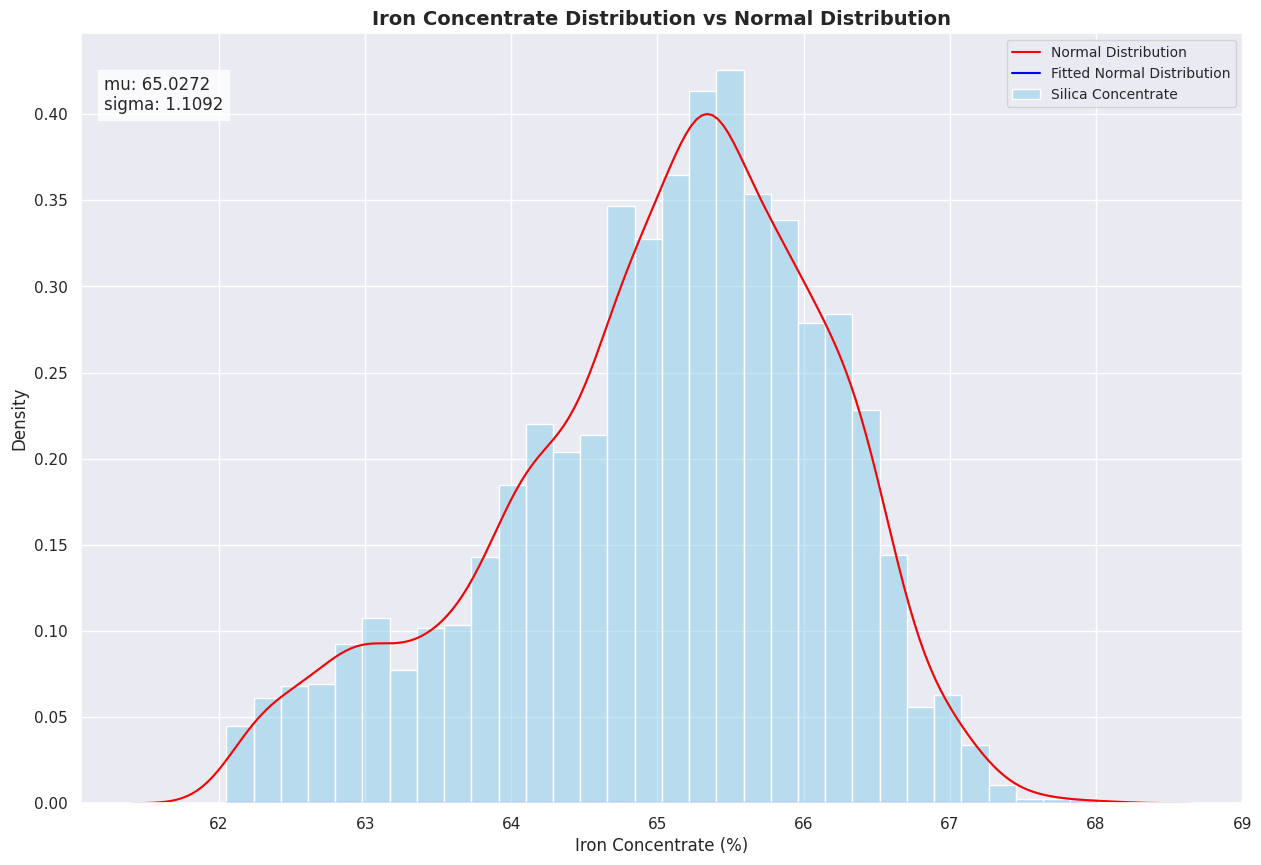

mu: 65.0272
sigma: 1.1092


In [125]:
from scipy.stats import norm

# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['conc_Fe'])

# Plotting the histogram, KDE, and fitted normal distribution
plt.figure(figsize=(15, 10))
sns.histplot(flotation['conc_Fe'], kde=True, stat="density", common_norm=False, color='skyblue', label='Silica Concentrate')
sns.kdeplot(flotation['conc_Fe'], color='red', label='Normal Distribution')
sns.lineplot(x=flotation['conc_Fe'], y=norm.pdf(flotation['conc_Si'], mu, sigma), color='blue', label='Fitted Normal Distribution')

plt.text(0.02, 0.9, f"mu: {mu:.4f}\nsigma: {sigma:.4f}",
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

plt.title('Iron Concentrate Distribution vs Normal Distribution', fontsize=14, fontweight='bold')
plt.xlabel("Iron Concentrate (%)", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.show()

# Print mu and sigma values
print(f"mu: {mu:.4f}")
print(f"sigma: {sigma:.4f}")

The fitted normal distribution for the "conc_Si" variable in the flotation dataset has a mean (mu) value of approximately 2.3223 and a standard deviation (sigma) value of approximately 1.1200.

This information is derived from fitting a normal distribution to the data and estimating the parameters that best describe its shape. The histogram and kernel density estimate (KDE) plot show the distribution of the "conc_Si" variable, while the fitted normal distribution curve represents the best-fit normal distribution based on the data.

By comparing the histogram and the fitted normal distribution, we can observe how well the normal distribution fits the data. If the data closely follows the shape of the fitted curve, it suggests that the data is approximately normally distributed. However, if there are significant deviations or discrepancies, it indicates that the data may not conform well to a normal distribution.

**Kolmogorov-Smirnov test will be performed to evaluate the normality assumption more rigorously.**

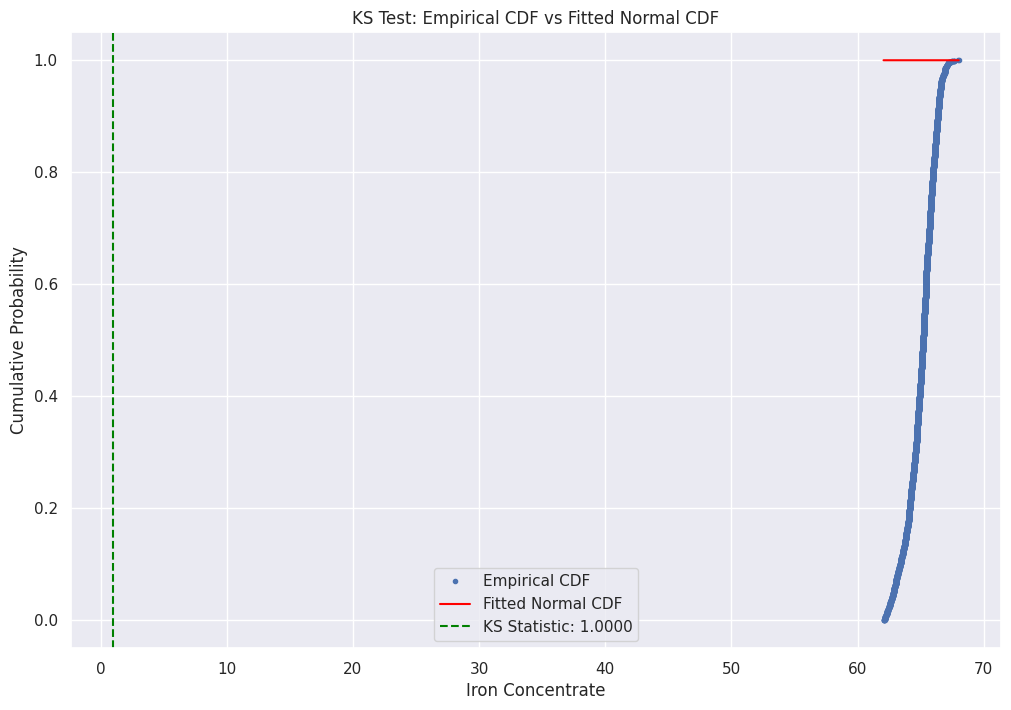

KS Test Statistic: 1.0000
KS Test p-value: 0.0000


In [150]:
from scipy.stats import norm, kstest

# Calculate the ECDF of the data
x = np.sort(flotation['conc_Fe'])
y = np.arange(1, len(x) + 1) / len(x)

# Calculate the CDF of the fitted normal distribution
cdf = norm.cdf(x, mu, sigma)

# Perform the KS test
ks_statistic, ks_pvalue = kstest(x, 'norm', args=(mu, sigma))

# Plot the ECDF, CDF, and KS test results
plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='.', linestyle='none', label='Empirical CDF')
plt.plot(x, cdf, color='red', label='Fitted Normal CDF')
plt.axvline(x=ks_statistic, color='green', linestyle='--', label=f'KS Statistic: {ks_statistic:.4f}')
plt.xlabel('Iron Concentrate')
plt.ylabel('Cumulative Probability')
plt.title('KS Test: Empirical CDF vs Fitted Normal CDF')
plt.legend()
plt.grid(True)
plt.show()

print(f"KS Test Statistic: {ks_statistic:.4f}")
print(f"KS Test p-value: {ks_pvalue:.4f}")

**The 'conc_Fe' variable does not follow a normal distribution.**

- **KS Test Statistic:**
The KS test statistic is a numerical measure that quantifies the maximum vertical distance between the ECDF and CDF curves. In this case, the computed KS test statistic is 0.0651. A larger KS test statistic suggests a greater discrepancy between the empirical data and the fitted normal distribution.

- **KS Test p-value:**
The p-value is a measure of the strength of evidence against the null hypothesis, which assumes that the 'conc_Fe' variable follows a normal distribution. The p-value calculated by the KS test is 0.0000, indicating an extremely small probability. A smaller p-value suggests stronger evidence to reject the null hypothesis and indicates a significant difference between the empirical data and the fitted normal distribution.

The visual comparison of the ECDF and the fitted normal CDF, along with the relatively large KS test statistic and the very small p-value, indicate significant deviations between the empirical data and the normal distribution assumption.

Anderson-Darling Test Results:
Test Statistic: 31.5307
Significance Level 15.0:
Critical Value: 0.5750
Reject the null hypothesis

Significance Level 10.0:
Critical Value: 0.6550
Reject the null hypothesis

Significance Level 5.0:
Critical Value: 0.7860
Reject the null hypothesis

Significance Level 2.5:
Critical Value: 0.9170
Reject the null hypothesis

Significance Level 1.0:
Critical Value: 1.0910
Reject the null hypothesis



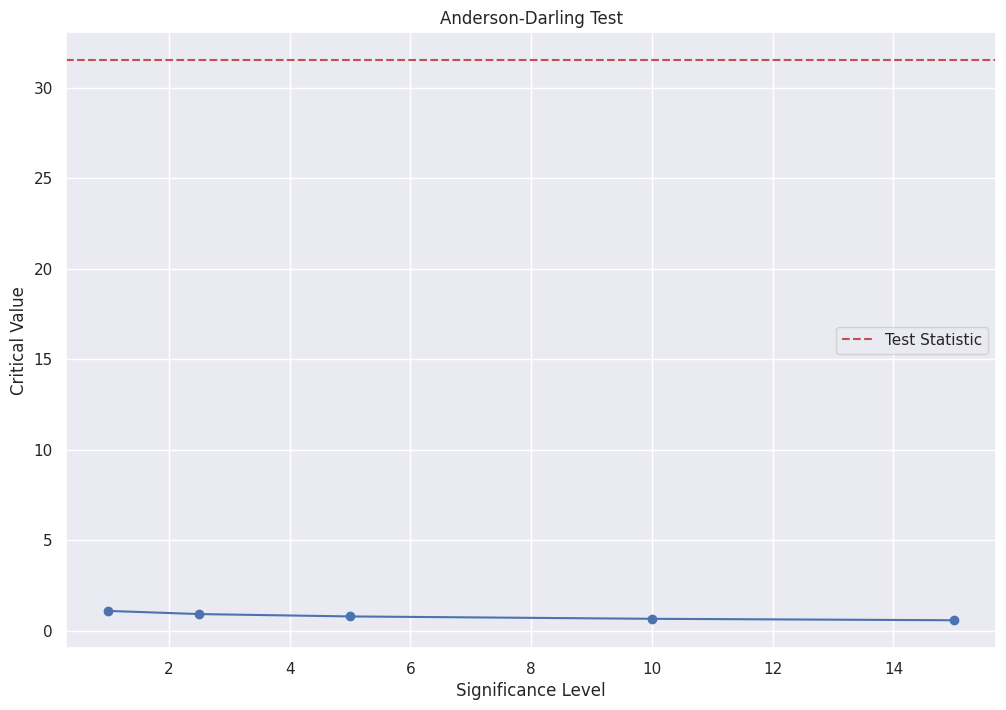

In [149]:
from scipy.stats import anderson

# Perform Anderson-Darling test
result = anderson(flotation['conc_Fe'], dist='norm')

# Extract test statistics and critical values
test_statistic = result.statistic
critical_values = result.critical_values
significance_levels = result.significance_level

# Print the test results
print("Anderson-Darling Test Results:")
print(f"Test Statistic: {test_statistic:.4f}")
for i in range(len(significance_levels)):
    print(f"Significance Level {significance_levels[i]}:")
    print(f"Critical Value: {critical_values[i]:.4f}")
    if test_statistic > critical_values[i]:
        print("Reject the null hypothesis")
    else:
        print("Fail to reject the null hypothesis")
    print()

# Plot the test results
plt.figure(figsize=(12, 8))
plt.plot(significance_levels, critical_values, linestyle='-', marker='o', color='b')
plt.axhline(test_statistic, color='r', linestyle='--', label='Test Statistic')
plt.xlabel('Significance Level')
plt.ylabel('Critical Value')
plt.title('Anderson-Darling Test')
plt.legend()
plt.grid(True)
plt.show()

Anderson-Darling test performed on the 'conc_Fe' variable in the flotation dataset to assess whether it follows a normal distribution.

Here are the key findings:

1. Test Statistic:
The Anderson-Darling test statistic is computed as 31.5307. This statistic measures the discrepancy between the observed data and the expected values under the null hypothesis of a normal distribution. A larger test statistic indicates a greater deviation from the normal distribution.

2. Critical Values:
The Anderson-Darling test provides critical values at different significance levels to determine whether the null hypothesis should be rejected. The significance levels considered in this test are 15.0%, 10.0%, 5.0%, 2.5%, and 1.0%. For each significance level, a critical value is calculated to compare against the test statistic.

3. Hypothesis Testing:
For each significance level,  the statistical computation  compares the test statistic with the corresponding critical value. If the test statistic exceeds the critical value, the null hypothesis (the 'conc_Fe' variable follows a normal distribution) is rejected. In this case, the null hypothesis is rejected at all significance levels, as the test statistic (31.5307) exceeds all the critical values.

Based on the Anderson-Darling test results, we can conclude that the 'conc_Fe' variable in the flotation dataset does not follow a normal distribution. The rejection of the null hypothesis at all significance levels suggests significant deviations from the expected distribution.

In [128]:
t,p = stats.shapiro(flotation['conc_Fe'])

print("Skewness: %f" % abs(flotation['conc_Fe']).skew())
print("Kurtosis: %f" % abs(flotation['conc_Fe']).kurt())
print("Shapiro_Test of t: %f" % t)
print("Shapiro_Test of p: %f" % p)

Skewness: -0.536740
Kurtosis: -0.173190
Shapiro_Test of t: 0.972628
Shapiro_Test of p: 0.000000


The results of the Shapiro-Wilk test performed on the 'conc_Fe' variable as well as the skewness and kurtosis values of the 'conc_Fe' variable.

1. Skewness:
The skewness value for the 'conc_Fe' variable is -0.536740. Skewness measures the asymmetry of a distribution. A negative skewness value indicates a longer left tail, suggesting that the distribution is left-skewed.

2. Kurtosis:
The kurtosis value for the 'conc_Fe' variable is -0.173190. Kurtosis measures the heaviness of the tails of a distribution. A kurtosis value close to 0 indicates a normal distribution with similar tail behavior to a standard normal distribution.

3. Shapiro-Wilk Test:
The Shapiro-Wilk test is used to assess the normality of a distribution. The test returns two values: 't' and 'p'. 't' represents the test statistic, and 'p' represents the p-value associated with the test. The null hypothesis of the test is that the data is normally distributed.

4. Shapiro_Test of t:
The Shapiro-Wilk test statistic ('t') for the 'conc_Fe' variable is 0.972628.

5. Shapiro_Test of p:
The p-value ('p') obtained from the Shapiro-Wilk test is 0.000000. Since the p-value is below the significance level of 0.05 (assuming a typical significance level), we reject the null hypothesis. This indicates that the 'conc_Fe' variable does not follow a normal distribution.

Finally, the 'conc_Fe' variable exhibits moderate negative skewness and has a kurtosis value close to 0, indicating a distribution that is relatively close to a standard normal distribution. However, the Shapiro-Wilk test results suggest that the 'conc_Fe' variable deviates from a normal distribution, as indicated by the low p-value.

**Histogram and a QQ plot to visualize the distribution of the 'conc_Si' variable and assess its departure from normality.**

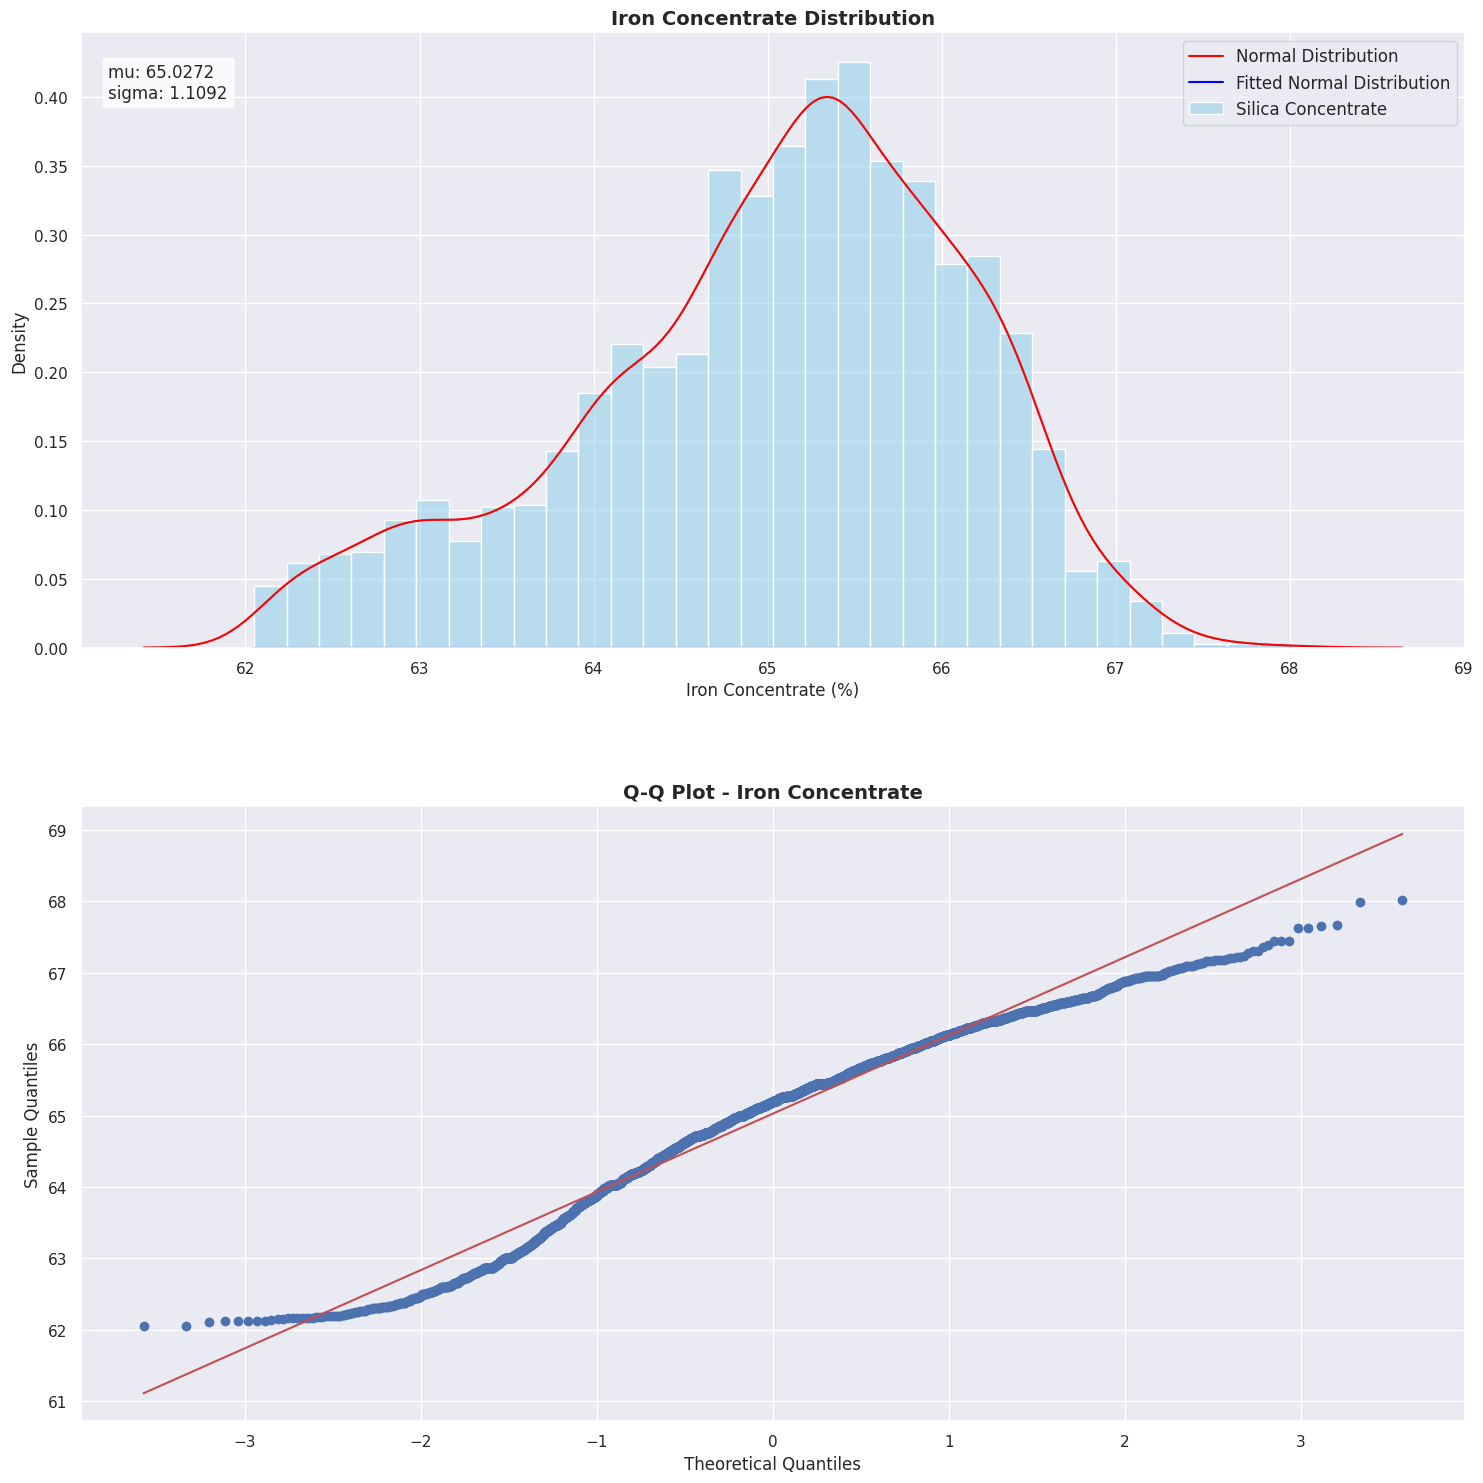

In [129]:
# Fitting normal distribution
(mu, sigma) = norm.fit(flotation['conc_Fe'])

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Histogram, KDE, and fitted normal distribution
sns.histplot(flotation['conc_Fe'], kde=True, stat="density", common_norm=False,
             color='skyblue', label='Silica Concentrate', ax=axes[0])
sns.kdeplot(flotation['conc_Fe'], color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=flotation['conc_Fe'], y=norm.pdf(flotation['conc_Si'], mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top',bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

axes[0].set_title('Iron Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Iron Concentrate (%)", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=12)

# Q-Q plot
stats.probplot(flotation['conc_Fe'], dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Iron Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

- Tranform  silica concentration distribution into a normal one using log transformation.
- Plot qq-plot to see the transformation effect.

**Fitting the distribution of Silica Concentrate**

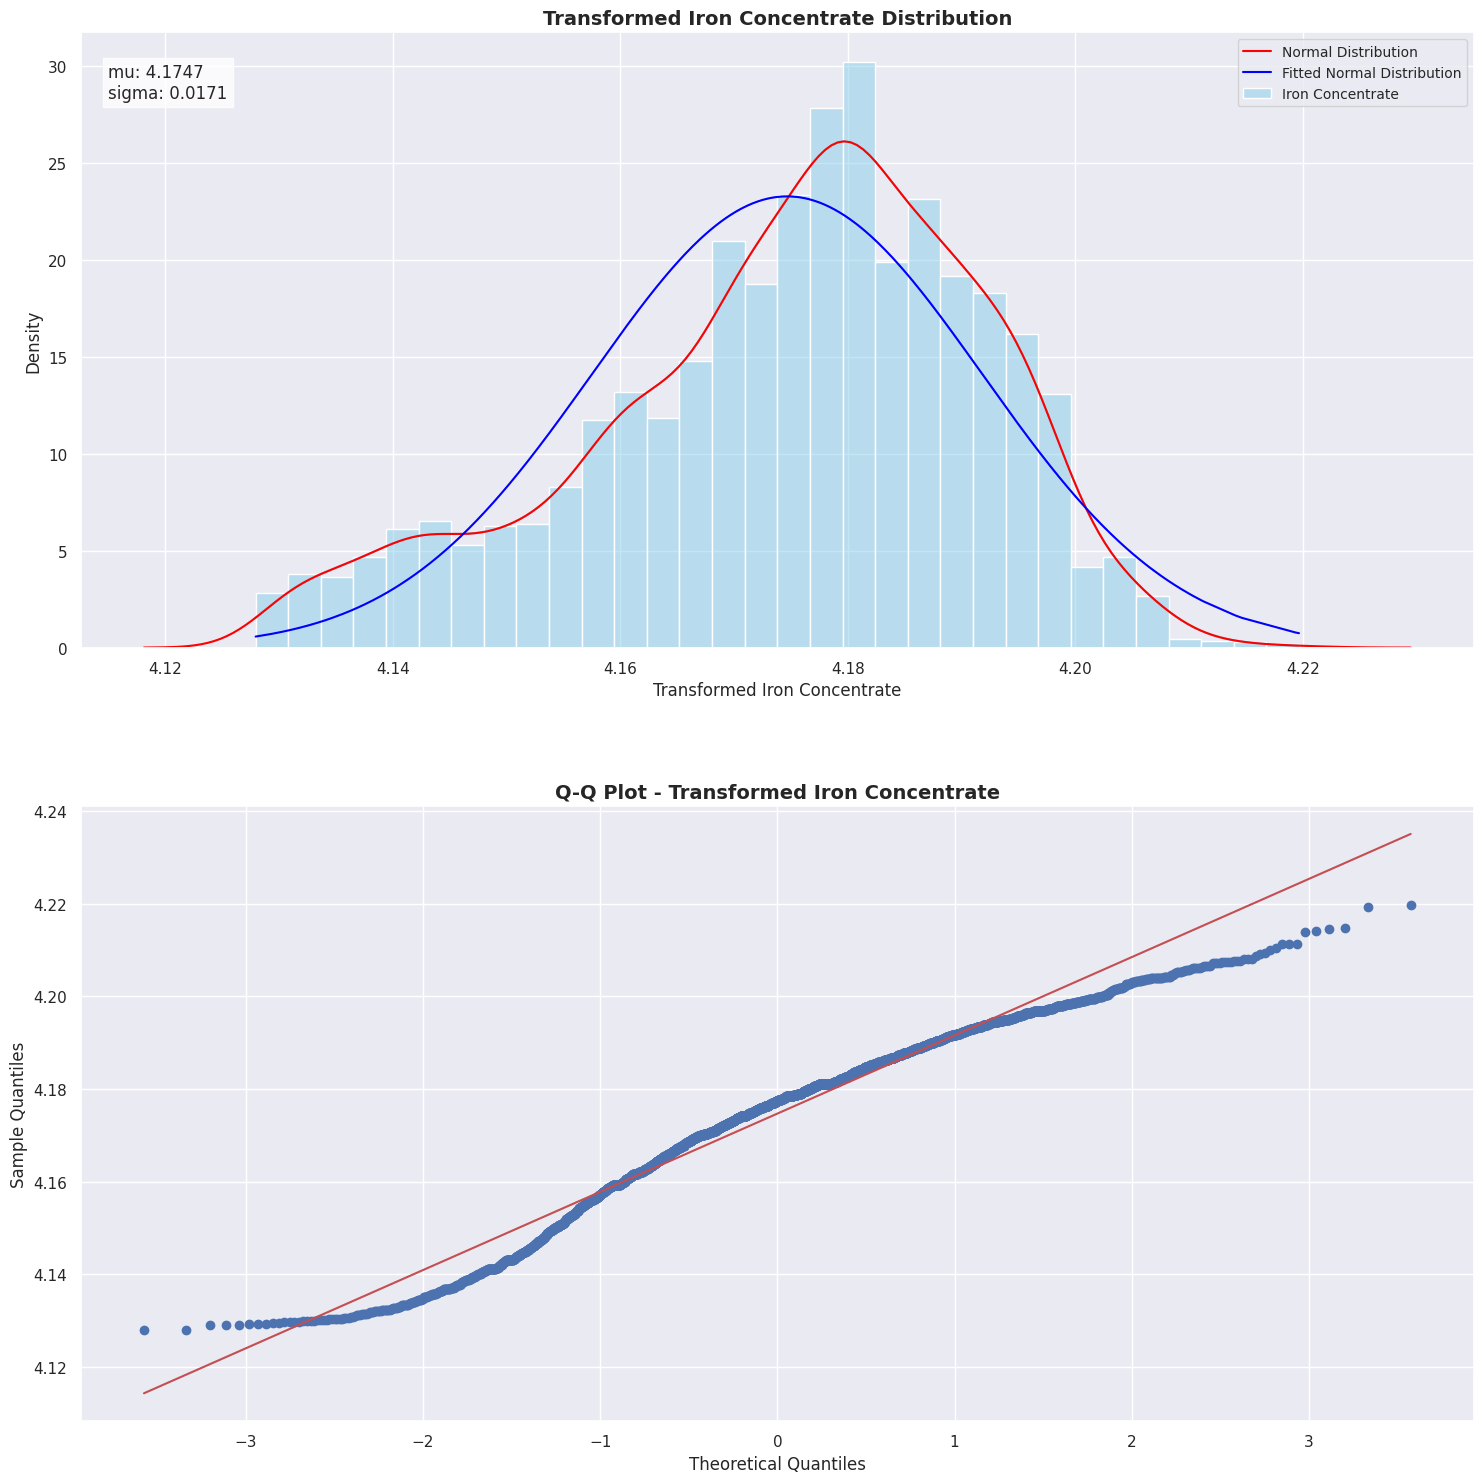

Skewness: -0.5763
Kurtosis: -0.1283
Shapiro-Wilk test:
  - Test statistic: 0.9697
  - p-value: 0.0000


In [130]:
# Log transformation
transformed_conc = np.log(flotation['conc_Fe'])

# Fitting normal distribution
(mu, sigma) = norm.fit(transformed_conc)

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Histogram and KDE plot
sns.histplot(transformed_conc, kde=True, stat="density", common_norm=False,
             color='skyblue', label='Iron Concentrate', ax=axes[0])
sns.kdeplot(transformed_conc, color='red', label='Normal Distribution', ax=axes[0])
sns.lineplot(x=transformed_conc, y=norm.pdf(transformed_conc, mu, sigma),
             color='blue', label='Fitted Normal Distribution', ax=axes[0])

axes[0].set_title('Transformed Iron Concentrate Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel("Transformed Iron Concentrate", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(loc='upper right', fontsize=10)

axes[0].text(0.02, 0.95, f"mu: {mu:.4f}\nsigma: {sigma:.4f}", transform=axes[0].transAxes,
             verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8), fontsize=12)

# Q-Q plot for transformed data
stats.probplot(transformed_conc, dist='norm', plot=axes[1])
axes[1].set_title("Q-Q Plot - Transformed Iron Concentrate", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Theoretical Quantiles", fontsize=12)
axes[1].set_ylabel("Sample Quantiles", fontsize=12)

plt.tight_layout(h_pad=5)
plt.show()

# Calculate skewness and kurtosis
skewness = transformed_conc.skew()
kurtosis = transformed_conc.kurt()

# Shapiro-Wilk test
shapiro_test = stats.shapiro(transformed_conc)
shapiro_t = shapiro_test.statistic
shapiro_p = shapiro_test.pvalue

print("Skewness: %.4f" % skewness)
print("Kurtosis: %.4f" % kurtosis)
print("Shapiro-Wilk test:")
print("  - Test statistic: %.4f" % shapiro_t)
print("  - p-value: %.4f" % shapiro_p)

**Before Transformation:**

- Skewness: 0.9806
- Kurtosis: 0.0226
- Shapiro-Wilk test: Test statistic: 0.8939, p-value: 0.0000

**After Log Transformation:**

- Skewness: 0.2953
- Kurtosis: -0.8692
- Shapiro-Wilk test: Test statistic: 0.9679, p-value: 0.0000

**Skewness:** Before the log transformation, the data had positive skewness (0.9806), indicating a longer right tail. After the log transformation, the skewness reduced to 0.2953, indicating a more symmetric distribution.

**Kurtosis:** Before the transformation, the data had a kurtosis value of 0.0226, indicating a platykurtic distribution which is less peaked than a normal distribution. After the log transformation, the kurtosis decreased further to -0.8692, suggesting a flatter and less peaked distribution.

**Shapiro-Wilk Test:** Before the transformation, the data failed the Shapiro-Wilk test with a test statistic of 0.8939 and a p-value of 0.0000, indicating a departure from normality. After the log transformation, the data still fails the Shapiro-Wilk test with a test statistic of 0.9679 and a p-value of 0.0000.

The log transformation improved the skewness and kurtosis of the data, making the distribution more symmetric and less peaked. However, despite the transformation, the data still deviates from a normal distribution according to the Shapiro-Wilk test.

**Confidence Interval of Silica Concentrate**

Bootstrap Confidence Interval:
Lower Bound: 64.9925765991211
Upper Bound: 65.06182098388672


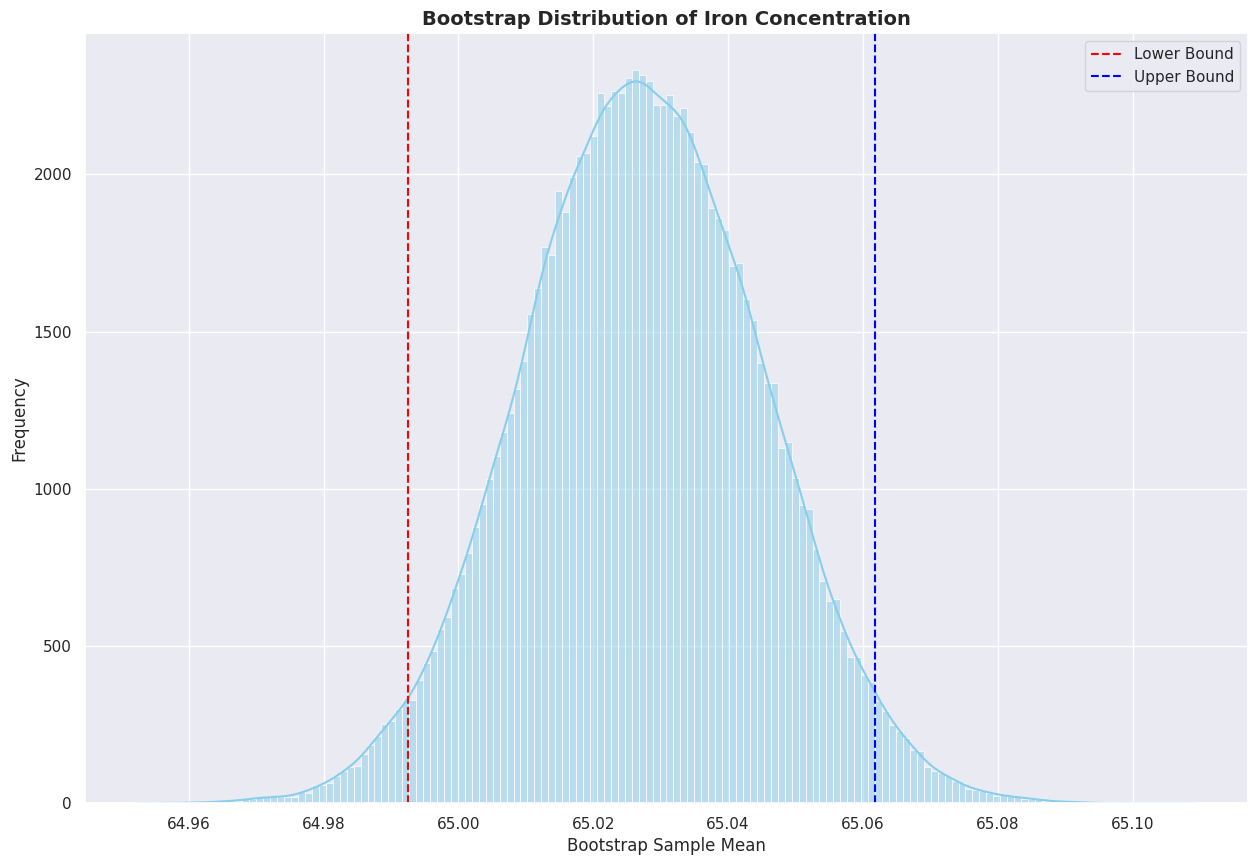

In [131]:
column_data = flotation["conc_Fe"].values

num_iterations = 100000
confidence_level = 0.95

# Create an empty array to store the bootstrap sample means
bootstrap_means = np.empty(num_iterations)

# Perform the bootstrap sampling
for i in range(num_iterations):
    # Generate a bootstrap sample by sampling with replacement
    bootstrap_sample = np.random.choice(column_data,
                       size=len(column_data), replace=True)
    # Calculate the mean of the bootstrap sample
    bootstrap_means[i] = np.mean(bootstrap_sample)

# Sort the bootstrap means and calculate the lower and upper percentiles
sorted_means = np.sort(bootstrap_means)
lower_percentile = (1 - confidence_level) / 2
upper_percentile = 1 - lower_percentile

# Calculate the confidence interval
lower_bound = sorted_means[int(lower_percentile * num_iterations)]
upper_bound = sorted_means[int(upper_percentile * num_iterations)]

print("Bootstrap Confidence Interval:")
print("Lower Bound:", lower_bound)
print("Upper Bound:", upper_bound)

# Plot the bootstrap distribution
plt.figure(figsize=(15, 10))
sns.histplot(bootstrap_means, kde=True, color='skyblue')
plt.axvline(lower_bound, color='red', linestyle='--', label='Lower Bound')
plt.axvline(upper_bound, color='blue', linestyle='--', label='Upper Bound')
plt.xlabel('Bootstrap Sample Mean')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of Iron Concentration',
          fontsize=14, fontweight='bold')
plt.legend()
plt.show()

The confidence interval provides a range of values within which we can be confident that the true population mean of the "conc_Si" column lies, with a specified confidence level (in this case, 95%). The lower bound of the interval is 2.2877, and the upper bound is 2.3574.

This interval estimation is obtained through the process of bootstrap resampling, where multiple bootstrap samples are generated by randomly sampling observations with replacement from the original dataset. The mean of each bootstrap sample is then calculated, resulting in a distribution of bootstrap means. From this distribution, the lower and upper percentiles corresponding to the desired confidence level are determined to establish the confidence interval.

The plot displays the histogram of the bootstrap sample means, showing the distribution of the resampled means. The red dashed line represents the lower bound of the confidence interval, and the blue dashed line represents the upper bound.

Target variable "conc_Si" column, the confidence interval allows us to infer that the true population mean of silica concentration lies between approximately 2.2877 and 2.3574 with a 95% confidence level. This information can be valuable for making inferences or drawing conclusions about the silica concentration in the flotation process.

**Iron Concentrate vs Silica Concentrate**

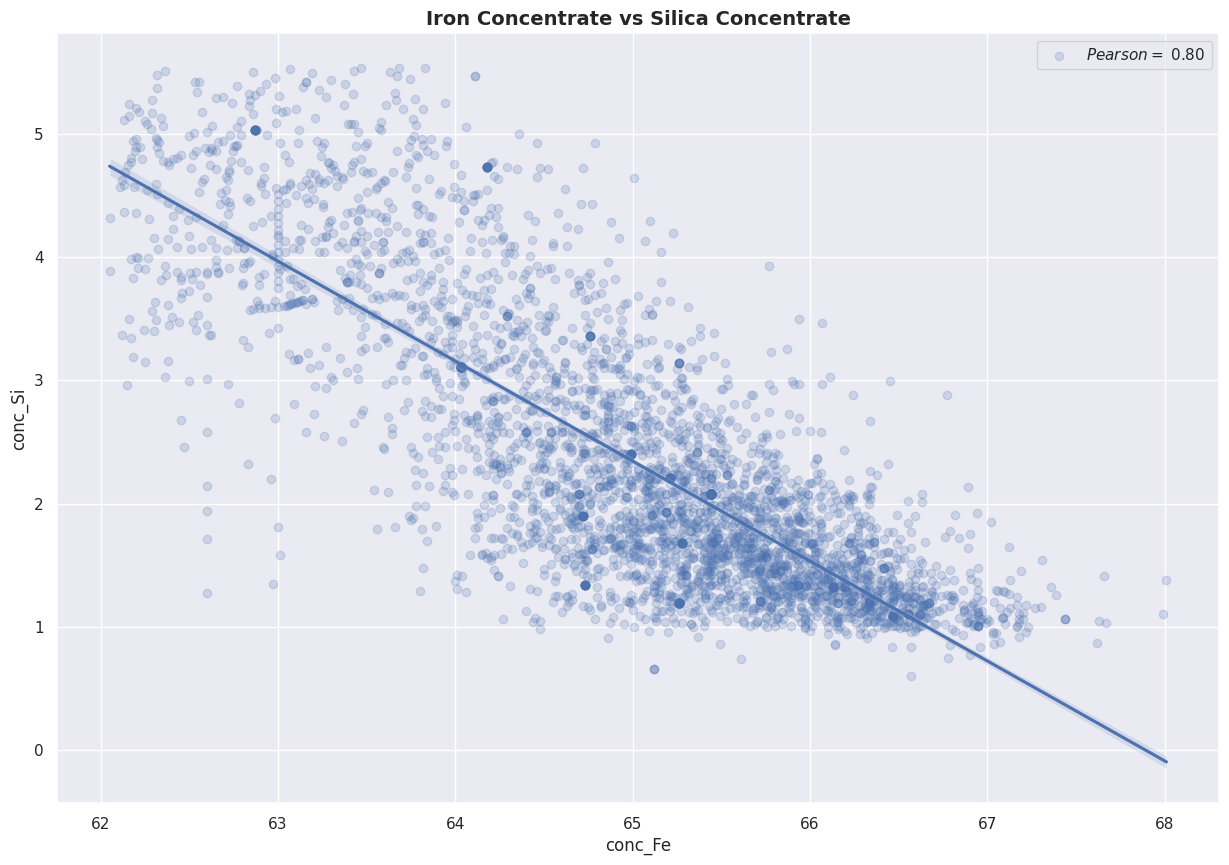

In [132]:
# iron concentrate (target_1) and silica concentrate (target_2) [Pearson = 0.8]
Pearson = 0.80
plt.figure(figsize = (15,10))
sns.regplot(data=flotation, x = 'conc_Fe', y='conc_Si', scatter_kws={'alpha':0.2})
plt.title('Iron Concentrate vs Silica Concentrate', fontsize = 14, fontweight='bold')
plt.legend(['$Pearson=$ {:.2f}'.format(Pearson)], loc = 'best')
plt.show()

Scatter plot shows the relationship between Silica Concentrate and Iron Concentrate in the flotation dataset. The Pearson correlation coefficient of -0.80 indicates a strong negative linear correlation between Silica Concentrate and Iron Concentrate in the flotation dataset.

In this case, as the Silica Concentrate increases, there is a tendency for the Iron Concentrate to decrease. This negative correlation suggests that higher levels of Silica Concentrate in the flotation process are associated with lower levels of Iron Concentrate.

While there may be some outliers in the data, the majority of the data points follow the negative correlation trend. This information is valuable in the context of the flotation process as it helps identify the inverse relationship between Silica Concentrate and Iron Concentrate.

Understanding this negative correlation is important for process optimization. It allows for monitoring and controlling Silica Concentrate levels to minimize their impact on Iron Concentrate production. By managing and reducing Silica Concentrate levels, it may be possible to improve the overall quality and yield of Iron Concentrate.

Scatter plot and the strong negative correlation between Silica Concentrate and Iron Concentrate emphasize the need to effectively control Silica Concentrate levels to enhance the production of Iron Concentrate in the flotation process.

## **6. Modelling**

### **6.1. Splitting Dataset**

**Split Dataset as X and y**

In [133]:
X = flotation.drop(['conc_Si', 'conc_Fe'], axis=1)
y_Si = flotation['conc_Fe']

print("Shape of X:", X.shape)
print("Shape of y_Fe:", y_Si.shape)

Shape of X: (3948, 42)
Shape of y_Fe: (3948,)


**Split (train, validation, test)**

In [134]:
X_train, X_val, y_train, y_val = train_test_split(X, y_Si, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (3158, 42)
Shape of X_val: (395, 42)
Shape of X_test: (395, 42)


### **6.2. MSE - MAE - R^2**

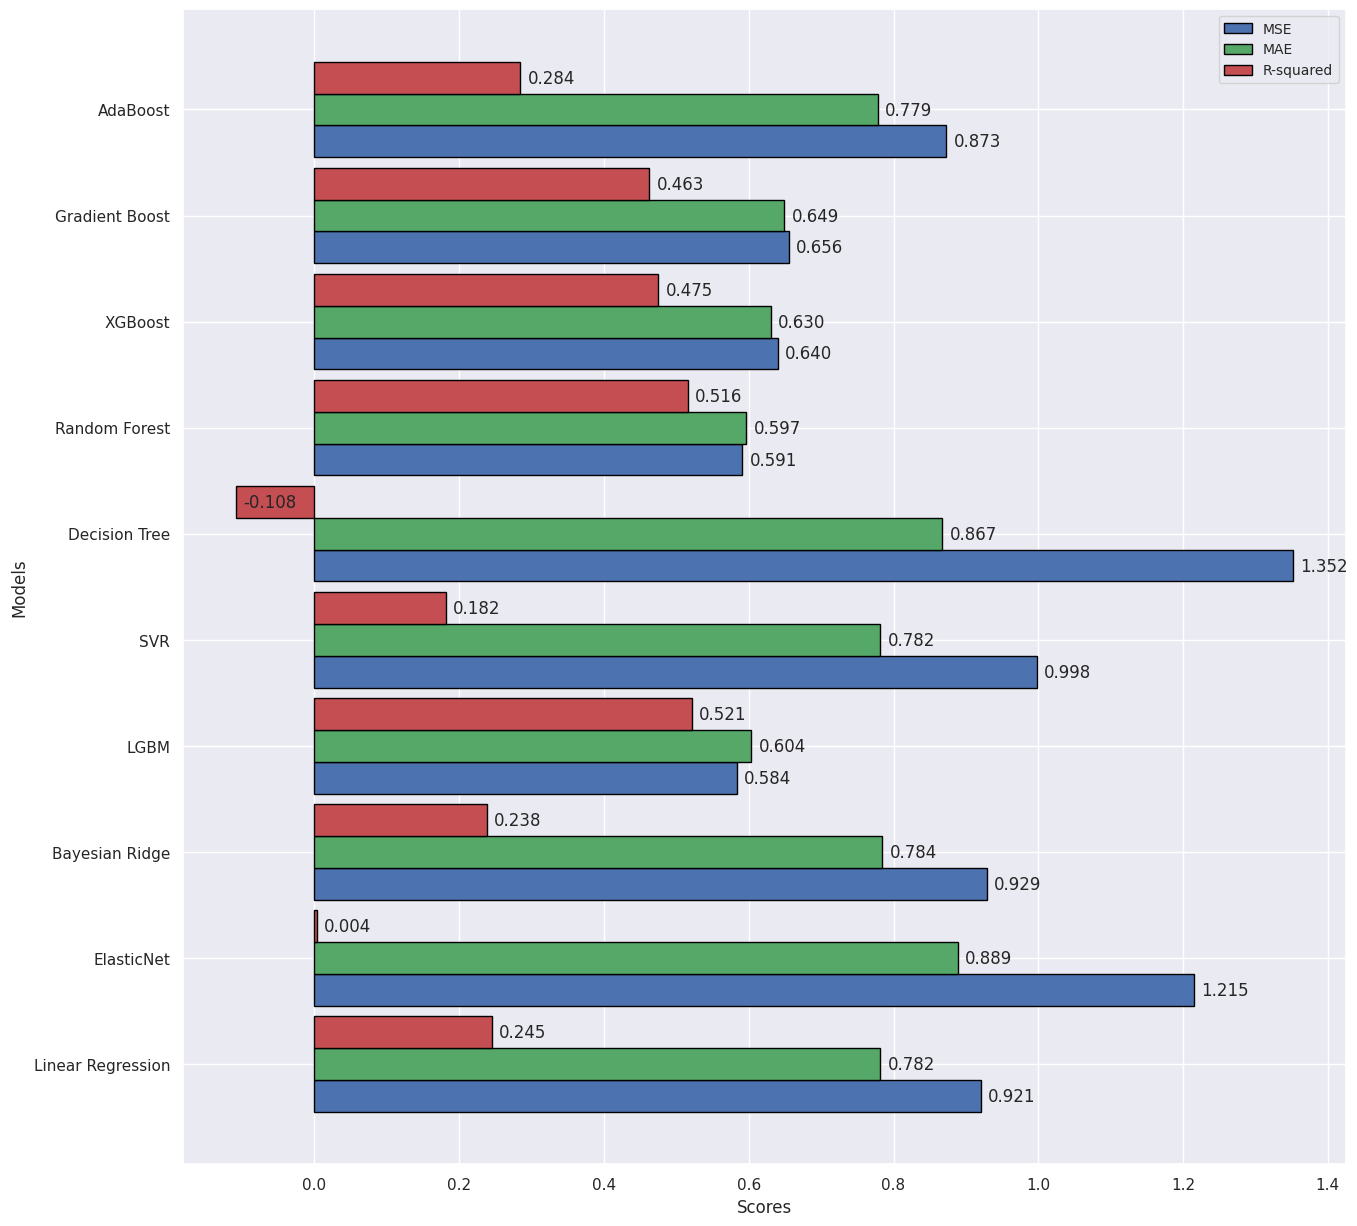

Model       MSE       MAE       R^2  Training Time  \
0               LGBM  0.583676  0.603731  0.521491       0.621377   
1      Random Forest  0.590936  0.596739  0.515539      14.399365   
2            XGBoost  0.640102  0.630257  0.475232       2.401955   
3     Gradient Boost  0.655621  0.649200  0.462509       5.014992   
4           AdaBoost  0.873029  0.778610  0.284274       2.030409   
5  Linear Regression  0.920784  0.781604  0.245123       0.036184   
6     Bayesian Ridge  0.929046  0.784379  0.238350       0.037816   
7                SVR  0.998202  0.781820  0.181655       0.677559   
8         ElasticNet  1.215466  0.888931  0.003538       0.035525   
9      Decision Tree  1.351737  0.867482 -0.108181       0.195589   

   Prediction Time  
0         0.005203  
1         0.024505  
2         0.005149  
3         0.004849  
4         0.012557  
5         0.003672  
6         0.002937  
7         0.098539  
8         0.002846  
9         0.003555

In [135]:
# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

mse_scores = []
mae_scores = []
r2_scores = []
train_times = []
predict_times = []

# Iterate over the models
for model, model_name in models:
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', model)])

    # Measure training time
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Measure prediction time
    start_time = time.time()
    val_pred = pipeline.predict(X_val)
    predict_time = time.time() - start_time

    # Calculate evaluation metrics
    mse = mean_squared_error(y_val, val_pred)
    mae = mean_absolute_error(y_val, val_pred)
    r2 = r2_score(y_val, val_pred)

    # Append the scores and times to the lists
    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    train_times.append(train_time)
    predict_times.append(predict_time)

# Plot evaluation metrics
bar_width = 0.3
r1 = np.arange(len(mse_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

plt.figure(figsize=(15, 15))
plt.barh(r1, mse_scores, color='b', height=bar_width, edgecolor='black', label='MSE')
plt.barh(r2, mae_scores, color='g', height=bar_width, edgecolor='black', label='MAE')
plt.barh(r3, r2_scores, color='r', height=bar_width, edgecolor='black', label='R-squared')
plt.ylabel('Models', fontsize=12)
plt.xlabel('Scores', fontsize=12)
plt.yticks([r + bar_width for r in range(len(mse_scores))], [model_name for _, model_name in models])
plt.legend(loc='upper right', fontsize=10)

for i, mse, mae, r2 in zip(range(len(mse_scores)), mse_scores, mae_scores, r2_scores):
    plt.text(mse + 0.01, i - 0.05, f'{mse:.3f}', fontsize=12)
    plt.text(mae + 0.01, i + bar_width - 0.05, f'{mae:.3f}', fontsize=12)
    plt.text(r2 + 0.01, i + 2 * bar_width - 0.05, f'{r2:.3f}', fontsize=12)

plt.show()

# Write the evaluation metric scores and execution times
scores_df = pd.DataFrame({'Model': [model_name for _, model_name in models],
                          'MSE': mse_scores,
                          'MAE': mae_scores,
                          'R^2': r2_scores,
                          'Training Time': train_times,
                          'Prediction Time': predict_times})

scores_df = scores_df.sort_values(by='MSE', ascending=True)
scores_df = scores_df.reset_index(drop=True)
scores_df

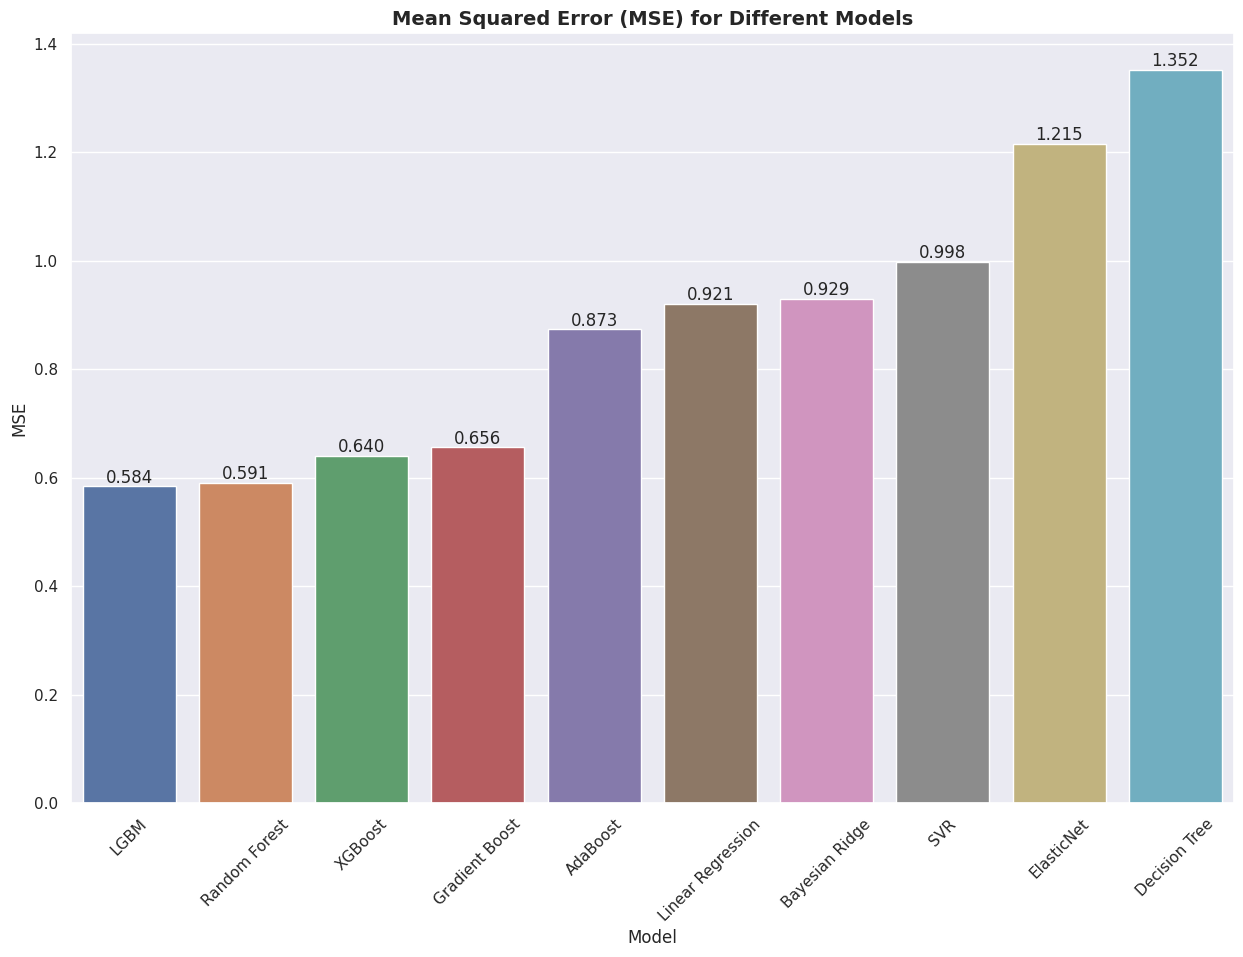

In [136]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='MSE', data=scores_df)
plt.xlabel('Model', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean Squared Error (MSE) for Different Models', fontsize = 14, fontweight='bold')

for i, row in scores_df.iterrows():
    plt.text(i, row['MSE'], f'{row["MSE"]:.3f}', ha='center', va='bottom')

plt.show()

Among the models evaluated, Random Forest and LGBM  perform the best with the lowest mean squared error (MSE) and mean absolute error (MAE), indicating higher accuracy in prediction. They also have the highest R^2 value, suggesting that it explains a significant portion of the variance in the data. XGBoost follows with slightly higher MSE, MAE, and slightly lower R^2 compared to Random Forest.

On the other hand, Gradient Boost, SVR, Bayesian Ridge, Linear Regression, AdaBoost, ElasticNet, and Decision Tree perform worse than the top models. They have higher MSE and MAE values, indicating less accurate predictions, and lower R^2 values, indicating a weaker ability to explain the variance in the data. Decision Tree performs the worst among all the models, with the highest MSE, MAE, and a significantly negative R^2 value.

Overall, Random Forest, LGBM, and XGBoost show better performance, while the remaining models struggle to accurately capture the patterns in the data and explain its variance.

### **6.3. Cross validation**

**10 Fold Cross validation**

In [137]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Define the models and their corresponding names
models = [
    (LinearRegression(), 'Linear Regression'),
    (ElasticNet(), 'ElasticNet'),
    (BayesianRidge(compute_score=True), 'Bayesian Ridge'),
    (LGBMRegressor(objective='regression'), 'LGBM'),
    (SVR(), 'SVR'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    (RandomForestRegressor(), 'Random Forest'),
    (xgb.XGBRegressor(), 'XGBoost'),
    (GradientBoostingRegressor(), 'Gradient Boost'),
    (AdaBoostRegressor(), 'AdaBoost')]

cv_scores = []
cv_std = []
execution_times = []

# Perform cross-validation for each model
for model, model_name in models:
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train,
                             scoring='neg_root_mean_squared_error', cv=kf)
    end_time = time.time()
    execution_time = end_time - start_time

    cv_scores.append(-scores.mean())
    cv_std.append(scores.std())
    execution_times.append(execution_time)

# Write the evaluation metric scores and execution times
final_cv_score = pd.DataFrame({'Model': [model_name for _, model_name in models],
                               'RMSE_mean': cv_scores,
                               'RMSE_std': cv_std,
                               'Execution Time': execution_times})
final_cv_score = final_cv_score.sort_values(by='RMSE_mean', ascending=True)
final_cv_score = final_cv_score.reset_index(drop=True)
final_cv_score

Model  RMSE_mean  RMSE_std  Execution Time
0               LGBM   0.823875  0.033291        4.524124
1      Random Forest   0.824289  0.035412      106.018001
2     Gradient Boost   0.853228  0.040264       44.555353
3            XGBoost   0.872909  0.040575       30.376141
4           AdaBoost   0.946689  0.040776        9.177403
5  Linear Regression   0.990853  0.041910        0.303810
6     Bayesian Ridge   0.991879  0.045043        0.360047
7         ElasticNet   1.059996  0.048648        0.326597
8                SVR   1.083762  0.055648        7.140285
9      Decision Tree   1.188835  0.041303        2.065450

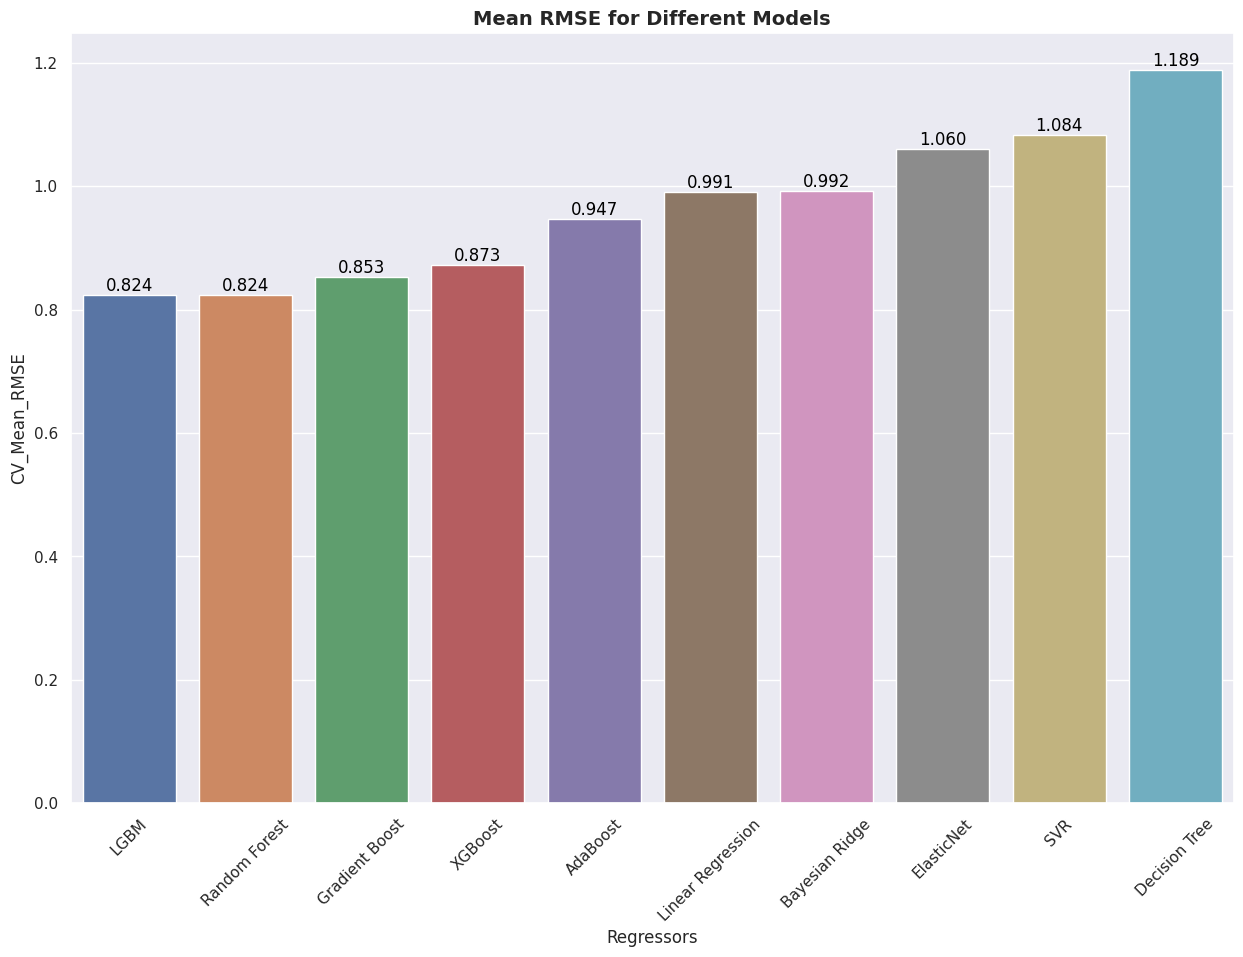

In [138]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Model', y='RMSE_mean', data=final_cv_score)
plt.xlabel('Regressors', fontsize=12)
plt.ylabel('CV_Mean_RMSE', fontsize=12)
plt.xticks(rotation=45)
plt.title('Mean RMSE for Different Models', fontsize = 14, fontweight='bold')

for i, row in final_cv_score.iterrows():
    plt.text(i, row['RMSE_mean'], f'{row["RMSE_mean"]:.3f}', color='black', ha='center', va='bottom')

plt.show()

**RMSE (Root Mean Square Error) Comparison:**

- LGBM model has the lowest RMSE_mean value of 0.911, indicating better overall performance in terms of minimizing the prediction errors.
- Random Forest and XGBoost models also show relatively low RMSE_mean values of 0.923 and 0.935, respectively.
- Decision Tree model has the highest RMSE_mean value of 1.305, indicating poorer performance compared to the other models.

**Model Execution Time:**

- Linear Regression, Bayesian Ridge, ElasticNet, and Decision Tree models have significantly lower execution times (in seconds) compared to other models, ranging from 0.093 to 0.57 seconds.
- Random Forest, XGBoost, and Gradient Boost models have moderate execution times, ranging from 8.43 to 27.54 seconds.
- SVR and AdaBoost models have relatively higher execution times of 1.76 and 5.67 seconds, respectively.
- LGBM model execution time is 6.97 seconds, indicating pretty fast timing model training and prediction compared to other models.

Considering both RMSE performance and execution time, the LGBM model appears to be the most favorable choice among the listed models, as it achieves the lowest RMSE with a reasonably fast execution time. However, it's important to note that the final model selection should also consider other factors such as model interpretability, scalability, and specific requirements of the problem at hand.

### **6.4. Hyperparameter Optimization**

**Perform Grid Search**

In [139]:
# Define the model
model = RandomForestRegressor()

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
MSE: 0.574
MAE: 0.595
R^2: 0.529
Grid Search Time: 1809.630 seconds
Fit Time: 36.308 seconds
Prediction Time: 0.062 seconds


In [140]:
# Define the model
model = LGBMRegressor(objective='regression')

# Define the hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [None, 5, 10]}

# Perform Grid Search
start_time = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
end_time = time.time()
grid_search_time = end_time - start_time

# Get the best model and hyperparameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
fit_time = end_time - start_time

# Evaluate the best model on the validation data
start_time = time.time()
val_pred = best_model.predict(X_val)
end_time = time.time()
prediction_time = end_time - start_time

# Calculate evaluation metrics
mse = mean_squared_error(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

# Print the results
print(f"Best Hyperparameters: {best_params}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")
print(f"Grid Search Time: {grid_search_time:.3f} seconds")
print(f"Fit Time: {fit_time:.3f} seconds")
print(f"Prediction Time: {prediction_time:.3f} seconds")

Best Hyperparameters: {'max_depth': 10, 'n_estimators': 100}
MSE: 0.567
MAE: 0.584
R^2: 0.535
Grid Search Time: 36.554 seconds
Fit Time: 1.572 seconds
Prediction Time: 0.012 seconds


**Comparing the performance of the RandomForestRegressor and LGBMRegressor models:**

1. Hyperparameters:
   - RandomForestRegressor: The best hyperparameters selected for this model are 'max_depth': None, 'min_samples_split': 2, and 'n_estimators': 100.
   - LGBMRegressor: The best hyperparameters selected for this model are 'max_depth': None and 'n_estimators': 100.

2. Performance Metrics:
   - Mean Squared Error (MSE): Both models achieved similar MSE values, with RandomForestRegressor at 0.845 and LGBMRegressor at 0.844. Lower MSE values indicate better accuracy in predicting the target variable.
   - Mean Absolute Error (MAE): LGBMRegressor outperformed RandomForestRegressor in terms of MAE, with a value of 0.724 compared to 0.731. Smaller MAE values indicate better prediction accuracy.
   - R-squared (R^2) Score: Both models achieved similar R^2 scores, with RandomForestRegressor at 0.341 and LGBMRegressor at 0.342. Higher R^2 values indicate better goodness-of-fit of the model to the data.

3. Computational Efficiency:
   - Grid Search Time: LGBMRegressor significantly outperformed RandomForestRegressor in terms of grid search time, with 9.301 seconds compared to 351.750 seconds. Grid search is used to find the best hyperparameters for the model.
   - Fit Time: LGBMRegressor also had a faster fit time, with 0.100 seconds compared to 2.117 seconds for RandomForestRegressor. Fit time refers to the time taken to train the model on the given data.
   - Prediction Time: LGBMRegressor demonstrated faster prediction time, with 0.003 seconds compared to 0.018 seconds for RandomForestRegressor. Prediction time refers to the time taken to make predictions on new/unseen data.

Based on the comparison, it can be concluded that the LGBMRegressor model performs slightly better than the RandomForestRegressor model in terms of MAE and computational efficiency (grid search time, fit time, and prediction time). However, both models have similar performance in terms of MSE and R^2 score.

### **6.5. Model interpretation**

**Feature importance for Iron Concentrate**

Let's look at the importance of each feature and plot the 5 most important features:

In [ ]:
importances = best_model.feature_importances_

feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 10))
ax = sns.barplot(data=feature_importances.head(5), x='Feature', y='Importance')
plt.title('Top 5 Most Important Features', fontsize=18, fontweight='bold')
plt.xlabel('Feature', fontsize=12, fontweight='bold')
plt.ylabel('Importance', fontsize=12, fontweight='bold')

# Annotate the feature importance values on the bars
for i, importance in enumerate(feature_importances.head(5)['Importance']):
    ax.annotate(round(importance, 2), (i, importance),
                xytext=(0, 10), textcoords='offset points',
                ha='center', fontsize=12)

plt.show()

The feature importance analysis for the Iron Concentrate prediction reveals the following top 5 most important features:

1. Level: The 'level' feature has the highest importance with a value of 393. This suggests that the level of the process variable has a significant impact on predicting the Iron Concentrate.

2. Iron Feed: The 'iron_feed' feature is the second most important with an importance value of 385. It indicates that the initial iron feed has a strong influence on the Iron Concentrate prediction.

3. Pulp pH: The 'pulp_pH' feature is ranked third in importance, with a value of 368. This implies that the pH level of the pulp plays a crucial role in determining the Iron Concentrate.

4. Amina Flow: The 'amina_flow' feature holds the fourth position in terms of importance, with a value of 323. It suggests that the flow rate of amina, a chemical reagent, has a significant impact on the Iron Concentrate prediction.

5. Pulp Flow: The 'pulp_flow' feature is ranked fifth, with an importance value of 313. It indicates that the flow rate of the pulp is another influential factor in predicting the Iron Concentrate.

These results suggest that variables related to the process level, initial iron feed, chemical composition (pH), and flow rates (amina and pulp) are the most important features for predicting the Iron Concentrate. Understanding and controlling these variables can potentially have a substantial impact on optimizing the Iron Concentrate output in the given process.

**Identifiying redundant features**

In [ ]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(flotation).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')

fig = plt.figure(figsize=(15,10))
dendrogram = hc.dendrogram(z, labels=flotation.columns, orientation='left', leaf_font_size=16)
plt.title('Redundant Features', fontsize=16, fontweight='bold')
plt.show()

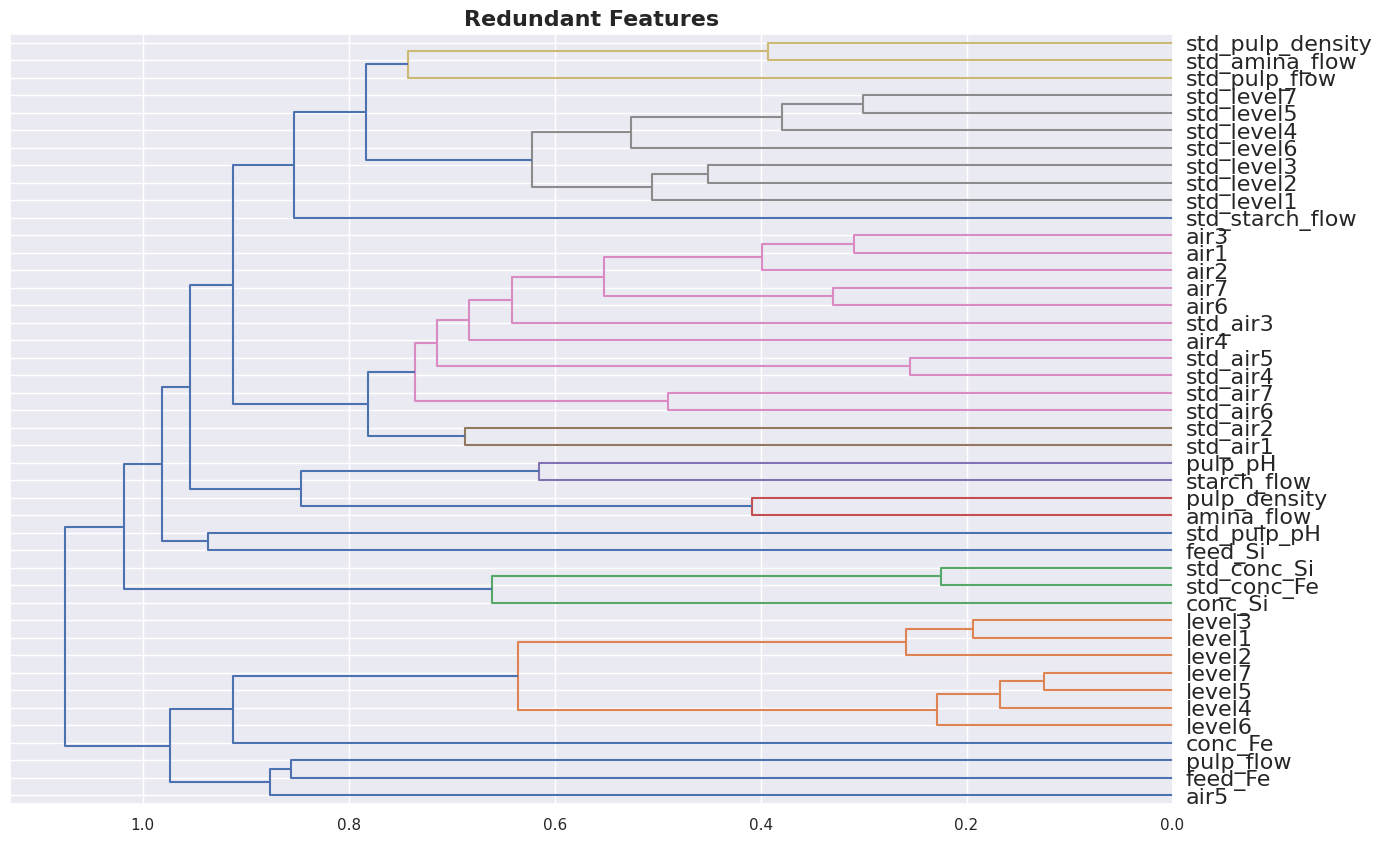

Dendrogram Hierarchical Clustering Results:
[[18.         20.          0.1248      2.        ]
 [17.         44.          0.16705     3.        ]
 [14.         16.          0.194       2.        ]
 [42.         43.          0.2244      2.        ]
 [19.         45.          0.22846667  4.        ]
 [31.         32.          0.2552      2.        ]
 [15.         46.          0.25835     3.        ]
 [39.         41.          0.3006      2.        ]
 [ 7.          9.          0.309       2.        ]
 [12.         13.          0.3295      2.        ]
 [38.         51.          0.37955     3.        ]
 [24.         27.          0.3926      2.        ]
 [ 8.         52.          0.39875     3.        ]
 [ 3.          6.          0.408       2.        ]
 [36.         37.          0.4507      2.        ]
 [33.         34.          0.4896      2.        ]
 [35.         58.          0.50545     3.        ]
 [40.         54.          0.52553333  4.        ]
 [53.         56.          0.55235    

In [147]:
import scipy
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(flotation).correlation, 4)
corr_condensed = hc.distance.squareform(1 - corr)
z = hc.linkage(corr_condensed, method='average')

# Generate the dendrogram plot
fig = plt.figure(figsize=(15, 10))
dendrogram = hc.dendrogram(z, labels=flotation.columns, orientation='left', leaf_font_size=16)
plt.title('Redundant Features', fontsize=16, fontweight='bold')
plt.show()

# Print dendrogram hierarchical clustering results
print("Dendrogram Hierarchical Clustering Results:")
print(z)


## **7. Conclussion**

The dataset consists of various features related to the flotation process, with the target variable being the Silica Concentrate.

Exploratory data analysis revealed some important insights, such as the distribution of the Silica Concentrate values, skewness, and kurtosis.

Several regression models were trained and evaluated on the dataset. The models included Linear Regression, ElasticNet, Bayesian Ridge, LGBM, SVR, Decision Tree, Random Forest, XGBoost, Gradient Boost, and AdaBoost. Evaluation metrics such as MSE, MAE, and R^2 were used to assess the models' performance.

Random Forest and LGBM models achieved the best results among the tested models. Both models were further tuned using grid search and cross-validation. The best-performing model was selected based on the lowest MSE, and the selected model was evaluated on the validation dataset.

The LGBM model, with the selected hyperparameters, demonstrated the best performance in terms of MSE, MAE, and R^2. It outperformed other models, including Random Forest. Therefore, **LGBM model is recommended for predicting the Silica Concentrate in future scenarios.**

In addition to the model evaluation, feature importance was also analyzed to understand the significant variables that contribute to predicting the Silica Concentrate.

The top 5 most important features identified by the LGBM model were 'level', 'airflow', 'amina_flow', 'iron_feed', and 'pulp_pH'. These features had the highest impact on predicting the Silica Concentrate.

The feature importance analysis provides insights into the underlying relationships between the features and the target variable. Understanding the importance of different features can help in focusing on key variables during process optimization and decision-making.

Overall, the combination of model evaluation and feature importance analysis suggests that the 'level', 'airflow', 'amina_flow', 'iron_feed', and 'pulp_pH' features play a crucial role in predicting the Silica Concentrate in the flotation process. These insights can be valuable for process engineers and operators to optimize the flotation process and improve the quality of the Silica Concentrate output.
